# <font style="font-size:40px"><center><b>Machine Learning</b></center></font><font                        style="font-size:30px"><center><b>Master in Computational Finance (MCF) </b></center></font> 

<center> 

# 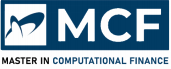

<center/>

# <font color='tomato' style="font-size:40px"><center><b>Homework 3</b></center></font></b></center></font> 

<center>
<b>profesor: </b> Nikola Vasiljevic

<b>students: </b> 
Nikola Krivacevic, Aleksandar Milinkovic
</center>





# Classification Methods 

## Importing Libraries

In [1]:
# Import / install relevant Python packages
import numpy as np
from numpy import where
import pandas as pd
from pandas import set_option
import datetime as dt
import statsmodels.api as sm
from scipy.stats import (randint, loguniform)

from collections import Counter

from sklearn.datasets import make_blobs
from sklearn.datasets import make_multilabel_classification

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import (RFE, RFECV, SelectFromModel)
from sklearn.model_selection import (KFold, GridSearchCV, RandomizedSearchCV, cross_val_score)
from sklearn import metrics
from sklearn.metrics import (classification_report, confusion_matrix)
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.use('ggplot')
import seaborn as sns


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importing Dataset - Credit Card Defaults in Taiwan in 2005

[`UCI Default of Credit Cards Dataset`](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) contains information regarding various variables on credit card clients in Taiwan.

In [2]:
from google.colab import files

uploaded = files.upload()

Saving UCI_Credit_Card.xlsx to UCI_Credit_Card (2).xlsx


## 1. Logistic Regression

Consider the Credit Card Default Dataset that was studied and extensively discused in the lectures.

### (a) Data preprocessing

- Provide a proposal on how to improve data preprocessing relative to the procedure described in the lecture notes. Consider possible additional transformations of features and treatment of outliers.
  - Remark: Focus on a couple of approaches that make most sense to you. This exercise serves rather as a test of the impact of further data preprocessing than as a quest for the best possible procedure. However, please put an effort in thinking about reasonable data transformations that could potentially improve the predictive power of your model(s).

- Evaluate the impact of the proposed data treatment algorithms on the performance of the logistic-regression-based classification method using the scaled training and testing data. Select the relevant performance metrics from those available in scikit-learn. For this exercise you do not have to generate any
charts—it is sufficient to tabulate your results.

#### Credit Card dataset EDA

Let's first explore and try to understand the credit card default dataset.

From the dataset description on the UC Irvine Machine Learning Repository site, we can find the following statement: **"Therefore, among the six data mining techniques, artificial neural network is the only one that can accurately estimate the real probability of default."**

Regarless of that, we're going to try to find the best logistic regression model and evaluate its performance. But straight away, knowign that logistic regression captures linear relationship for classification and that neural networks are great for capturing nonlinear relationships in the dataset, we expect that this dataset exibits some nonlinear behaviour.

Dataset contains infromation about **credit card clients in Taiwan from April 2005 - September 2005**.  The target variable is a binary variable (**binary classification**) - default payment (Yes = 1, No = 0). 

There are 23 explanatory variables:

1. `LIMIT_BAL`: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
2. `SEX`: Gender (1 = male; 2 = female).
3. `EDUCATION`: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
4. `MARRIAGE`: Marital status (1 = married; 2 = single; 3 = others).
5. `AGE`: Age (year).
6. .. 11. `PAY_0 .. PAY_6`: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
12. .. 17. `BILL_AMT1 .. BILL_AMT6`: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
18. .. 23. `PAY_AMT1 .. PAY_AMT6`: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [3]:
data = pd.read_excel('UCI_Credit_Card.xlsx')
data.sample(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
332,333,60000,2,1,2,28,1,2,0,0,0,0,10540,10232,11237,11427,20973,31857,0,1483,673,10000,11540,7000,0
5202,5203,60000,1,3,1,58,2,2,0,0,2,0,22658,22703,23495,24349,23960,24530,700,1546,1400,0,900,0,0
20666,20667,50000,1,2,1,35,0,0,0,0,0,0,20274,44996,21147,21964,21405,20297,2600,1800,1500,1000,1000,1000,0
8489,8490,180000,2,2,2,34,-1,-1,-1,-1,-1,-1,194,191,187,176,188,187,200,187,180,200,187,750,0
13608,13609,320000,1,1,1,46,-1,-1,-1,0,0,0,10836,19751,72623,61459,44390,29773,19799,73706,1692,1023,761,67235,0


In [4]:
# EDA: Edit the name of the last variable and drop the column ID
data.rename(columns={'default payment next month': 'DEFAULT'}, inplace=True)
data.drop('ID', axis = 1, inplace =True) 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

In [5]:
data.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


##### Redoing data processing from the lecture

Issues with categorical variables (based on dataset description):

In [6]:
# EDA: Print unique values for selected features
print('Gender (1 = male; 2 = female):')
print(sorted(data['SEX'].unique()))
print('-'*100)
print('Education (1 = graduate school; 2 = university; 3 = high school; 4 = others):')
print(sorted(data['EDUCATION'].unique()))
print('-'*100)
print('Marital status (1 = married; 2 = single; 3 = others):')
print(sorted(data['MARRIAGE'].unique()))
print('-'*100)
print('Payment status (-1 = pay duly; K = payment delay for K months, for K=1,2,...,8; 9 = payment delay for nine months and above):')
print(sorted(data['PAY_0'].unique()))
print(sorted(data['PAY_2'].unique()))
print(sorted(data['PAY_3'].unique()))
print(sorted(data['PAY_4'].unique()))
print(sorted(data['PAY_5'].unique()))
print(sorted(data['PAY_6'].unique()))
print('-'*100)

Gender (1 = male; 2 = female):
[1, 2]
----------------------------------------------------------------------------------------------------
Education (1 = graduate school; 2 = university; 3 = high school; 4 = others):
[0, 1, 2, 3, 4, 5, 6]
----------------------------------------------------------------------------------------------------
Marital status (1 = married; 2 = single; 3 = others):
[0, 1, 2, 3]
----------------------------------------------------------------------------------------------------
Payment status (-1 = pay duly; K = payment delay for K months, for K=1,2,...,8; 9 = payment delay for nine months and above):
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]
----------------------------------------------------------------------------------------------------


In [7]:
# EDA: Correct the encoding for the variable EDUCATION
data['EDUCATION']=np.where(data['EDUCATION'] == 5, 4, data['EDUCATION'])
data['EDUCATION']=np.where(data['EDUCATION'] == 6, 4, data['EDUCATION'])
data['EDUCATION']=np.where(data['EDUCATION'] == 0, 4, data['EDUCATION'])

In [8]:
# EDA: Correct the encoding for the variable MARRIAGE
data['MARRIAGE']=np.where(data['MARRIAGE'] == 0, 3, data['MARRIAGE'])

In [9]:
# EDA: Print unique values for selected variables
print('Education (1 = graduate school; 2 = university; 3 = high school; 4 = others):')
print(sorted(data['EDUCATION'].unique()))
print('-'*100)
print('Marital status (1 = married; 2 = single; 3 = others):')
print(sorted(data['MARRIAGE'].unique()))
print('-'*100)

Education (1 = graduate school; 2 = university; 3 = high school; 4 = others):
[1, 2, 3, 4]
----------------------------------------------------------------------------------------------------
Marital status (1 = married; 2 = single; 3 = others):
[1, 2, 3]
----------------------------------------------------------------------------------------------------


##### Looking into PAY_X fetures (problems with -2 and 0 values)

Let's see how many observations have a problematic values:

In [10]:
pay_zero_values = []
pay_minus_two_values = []
pay_minus_one_values = []
pay_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for c in pay_columns:
  pay_zero_values.append(data[data[c] == 0].shape[0])
  pay_minus_two_values.append(data[data[c] == -2].shape[0])
  pay_minus_one_values.append(data[data[c] == -1].shape[0])

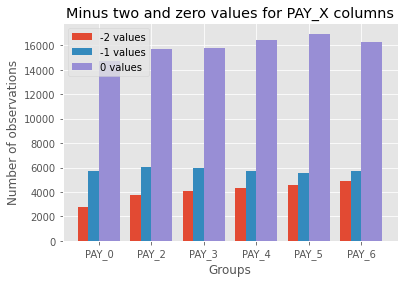

In [11]:
ax = plt.subplot(111)

X_axis = np.arange(len(pay_columns))
ax.bar(X_axis - 0.2, pay_minus_two_values, 0.4, label="-2 values")
ax.bar(X_axis, pay_minus_one_values, 0.4, label="-1 values")
ax.bar(X_axis + 0.2, pay_zero_values, 0.4, label="0 values")

plt.xticks(X_axis, pay_columns)
plt.xlabel("Groups")
plt.ylabel("Number of observations")
plt.title("Minus two and zero values for PAY_X columns")
plt.legend()
plt.show()

In [12]:
print(f"Total number of observations: {data.shape[0]}.")

Total number of observations: 30000.


Nearly half of observations have a zero value for PAY_X features, which is unfamiliar indicator, according to the dataset specification/description. Those observations and values we won't chage.


Let's try and see what is the effect on dataset and classification models when we replace values of `-2` with value of `-1`, which is a legitimate value according to the dataset documentation.


In [13]:
for c in pay_columns:
  data[c]=np.where(data[c] == -2, -1, data[c])

##### Additional EDA

Now we'll look into some additional properties of this dataset. We'll look into three groups of columns:
- PAY_X columns
- BILL_AMT_X columns
- PAY_AMT_X columns

In [14]:
data.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT'],
      dtype='object')

1. PAY_X columns

In [15]:
pay_data = data[['DEFAULT', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
pay_data_correlations = pay_data.corr()
pay_data_correlations

,DEFAULT,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
DEFAULT,1.000000,0.348519,0.293328,0.263203,0.246325,0.236175,0.217742
PAY_0,0.348519,1.000000,0.668103,0.545119,0.510106,0.479601,0.442943
PAY_2,0.293328,0.668103,1.000000,0.715964,0.604400,0.567186,0.520759
PAY_3,0.263203,0.545119,0.715964,1.000000,0.727571,0.630321,0.579775
PAY_4,0.246325,0.510106,0.604400,0.727571,1.000000,0.778107,0.667906
PAY_5,0.236175,0.479601,0.567186,0.630321,0.778107,1.000000,0.774978
PAY_6,0.217742,0.442943,0.520759,0.579775,0.667906,0.774978,1.000000


Text(0.5, 1.0, 'PAY_X correlation heatmap')

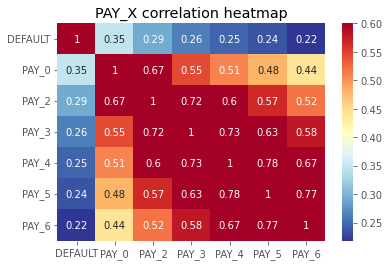

In [16]:
sns.heatmap(pay_data_correlations, cmap = plt.cm.RdYlBu_r, annot=True, vmax=0.6)
plt.title('PAY_X correlation heatmap')

All six PAY_X features have small positive correlation with DEFAULT column. That means the more the PAY_X increases (customer is late for payments), the more DEFAULT increases - becomes 1 (higher probability of defaulting), which logically makes sense.

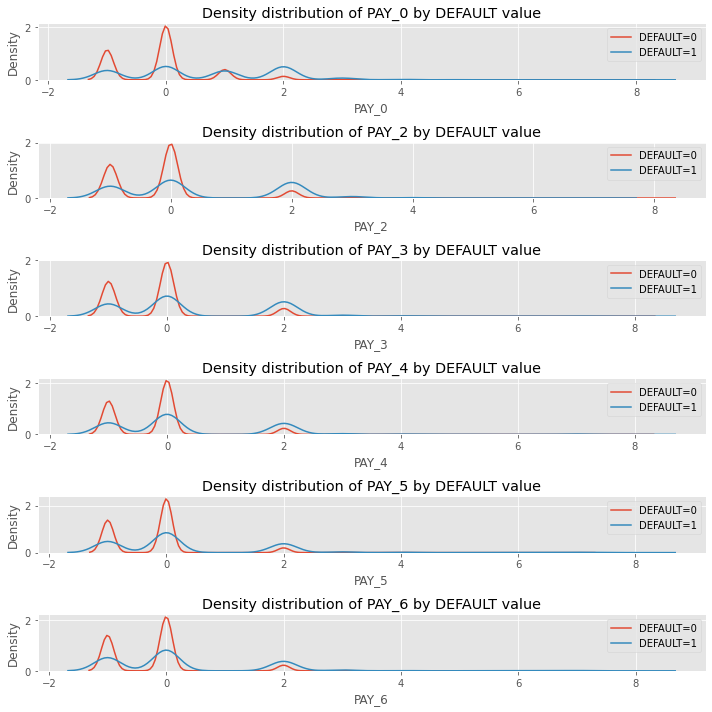

In [17]:
# Distribution of PAY columns compared to DEFAULT column (density function - KDE)
# We visualize the effect of PAY feature on DEFAULT column 

plt.figure(figsize=(10, 10))

pay_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for i, column_name in enumerate(pay_columns):
    plt.subplot(6, 1, i + 1)
    
    sns.kdeplot(data[data['DEFAULT'] == 0][column_name], label='DEFAULT=0')
    sns.kdeplot(data[data['DEFAULT'] == 1][column_name], label='DEFAULT=1')
    
    plt.xlabel(column_name)
    plt.legend()
    plt.ylabel('Density')
    plt.title(f'Density distribution of {column_name} by DEFAULT value')    
    
plt.tight_layout()

From the PAY features density distributions for defaulted and non-defaultet customers, we can see that the interesting thing is that when the customer is 2 months late for payments there is spike in defaults, more dafaults than non defaults. We can also see substantial spike in defaults for customers that are not late for payments (-1, and 0 values for PAY features).

2. BILL_ATM_X features

In [18]:
bill_data = data[['DEFAULT', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
bill_data_correlations = bill_data.corr()
bill_data_correlations

,DEFAULT,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
DEFAULT,1.000000,-0.019644,-0.014193,-0.014076,-0.010156,-0.006760,-0.005372
BILL_AMT1,-0.019644,1.000000,0.951484,0.892279,0.860272,0.829779,0.802650
BILL_AMT2,-0.014193,0.951484,1.000000,0.928326,0.892482,0.859778,0.831594
BILL_AMT3,-0.014076,0.892279,0.928326,1.000000,0.923969,0.883910,0.853320
BILL_AMT4,-0.010156,0.860272,0.892482,0.923969,1.000000,0.940134,0.900941
BILL_AMT5,-0.006760,0.829779,0.859778,0.883910,0.940134,1.000000,0.946197
BILL_AMT6,-0.005372,0.802650,0.831594,0.853320,0.900941,0.946197,1.000000


Text(0.5, 1.0, 'BILL_ATM_X correlation heatmap')

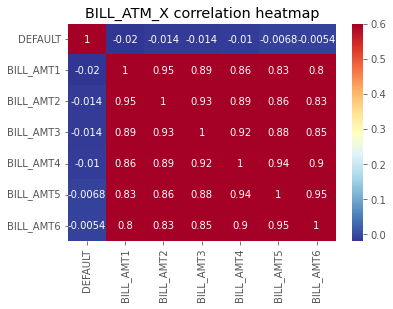

In [19]:
sns.heatmap(bill_data_correlations, cmap = plt.cm.RdYlBu_r, annot=True, vmax=0.6)
plt.title('BILL_ATM_X correlation heatmap')

Now in this correlation plot there is practically zero correlation with DEFAULT/TARGET varable. And the correlations among BILL_ATM_X features is extremly high.

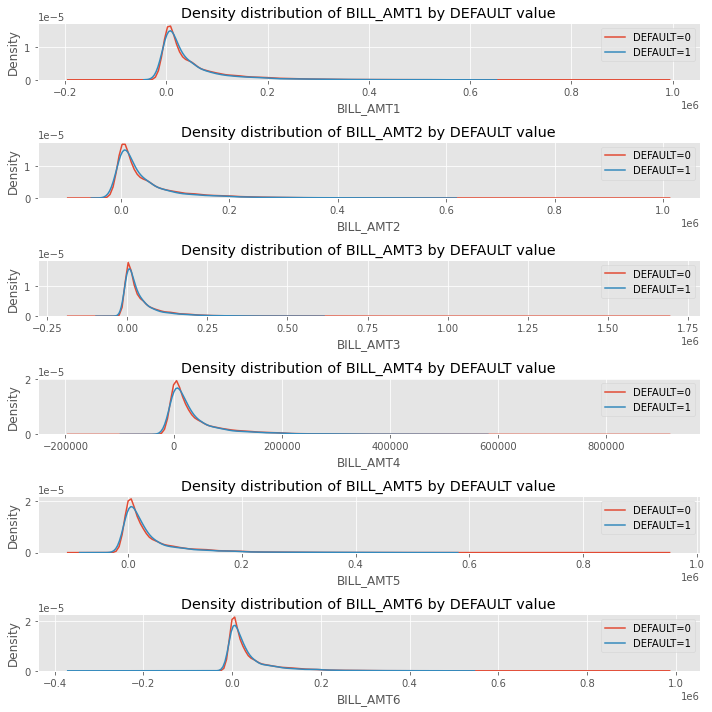

In [20]:
# Distribution of BILL_ATM_X columns compared to DEFAULT column (density function - KDE)
# We visualize the effect of BILL_ATM_X feature on DEFAULT column 

plt.figure(figsize=(10, 10))

bill_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

for i, column_name in enumerate(bill_columns):
    plt.subplot(6, 1, i + 1)
    
    sns.kdeplot(data[data['DEFAULT'] == 0][column_name], label='DEFAULT=0')
    sns.kdeplot(data[data['DEFAULT'] == 1][column_name], label='DEFAULT=1')
    
    plt.xlabel(column_name)
    plt.legend()
    plt.ylabel('Density')
    plt.title(f'Density distribution of {column_name} by DEFAULT value')    
    
plt.tight_layout()

3. PAY_AMT_X features

In [21]:
pay_atm_data = data[['DEFAULT', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
pay_atm_data_correlations = pay_atm_data.corr()
pay_atm_data_correlations

,DEFAULT,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
DEFAULT,1.000000,-0.072929,-0.058579,-0.056250,-0.056827,-0.055124,-0.053183
PAY_AMT1,-0.072929,1.000000,0.285576,0.252191,0.199558,0.148459,0.185735
PAY_AMT2,-0.058579,0.285576,1.000000,0.244770,0.180107,0.180908,0.157634
PAY_AMT3,-0.056250,0.252191,0.244770,1.000000,0.216325,0.159214,0.162740
PAY_AMT4,-0.056827,0.199558,0.180107,0.216325,1.000000,0.151830,0.157834
PAY_AMT5,-0.055124,0.148459,0.180908,0.159214,0.151830,1.000000,0.154896
PAY_AMT6,-0.053183,0.185735,0.157634,0.162740,0.157834,0.154896,1.000000


Text(0.5, 1.0, 'PAY_ATM_X correlation heatmap')

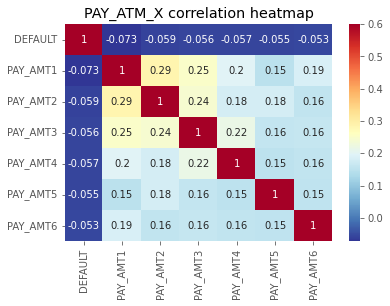

In [22]:
sns.heatmap(pay_atm_data_correlations, cmap = plt.cm.RdYlBu_r, annot=True, vmax=0.6)
plt.title('PAY_ATM_X correlation heatmap')

Again, insignificant correlation with DEFAULT/TARGET feature and relatively low correlation among features themselves.

##### Scaling dataset

In [23]:
# Scale features
scaler = StandardScaler()

scaled_data = scaler.fit_transform(data.drop(labels=['DEFAULT'], axis=1))
X = scaled_data
y = data['DEFAULT']

X.shape, y.shape

((30000, 23), (30000,))

In [24]:
# DataFrame for scaled data
scaled_data_df = pd.DataFrame(scaled_data, columns=data.drop(labels=['DEFAULT'], axis=1).columns)
scaled_data_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1.136720,0.810161,0.21187,-1.068797,-1.246020,1.942687,1.938346,-0.946291,-0.936042,-0.939939,-0.918576,-0.642501,-0.647399,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382
1,-0.365981,0.810161,0.21187,0.849131,-1.029047,-1.085297,1.938346,0.029300,0.076698,0.121739,2.241421,-0.659219,-0.666747,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878
2,-0.597202,0.810161,0.21187,0.849131,-0.161156,-0.075969,0.007434,0.029300,0.076698,0.121739,0.134756,-0.298560,-0.493899,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122
3,-0.905498,0.810161,0.21187,-1.068797,0.164303,-0.075969,0.007434,0.029300,0.076698,0.121739,0.134756,-0.057491,-0.013293,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130
4,-0.905498,-1.234323,0.21187,-1.068797,2.334029,-1.085297,0.007434,-0.946291,0.076698,0.121739,0.134756,-0.578618,-0.611318,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187


Let's now also split our dataset into the:
- Training set (80% of the observations ~ 24,000 observations)
- Testing set (20% of the observations ~ 6,000 observations)

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Features: train={len(X_train)} test={len(X_test)}')
print(f'Target: train={len(y_train)} test={len(y_test)}')

Features: train=24000 test=6000
Target: train=24000 test=6000


In [26]:
print("Percentage of defaults in:")
print(f"1. Training sample: {round(sum(y_train)/len(y_train)*100, 2)} %")
print(f"2. Testing sample: {round(sum(y_test)/len(y_test)*100, 2)} %")

Percentage of defaults in:
1. Training sample: 22.18 %
2. Testing sample: 21.88 %


We've splitted dataset into the training and testing datasets and we can see that the ratio of defaults in the both sets is nearly the same.

#### Feature Engineering

In this section feature engineering is perfomed. We'll going to try with couple approaches to create/design better features and fit models using those features and evaluate them.

We're going to:
- Find and select the optimal number of features from the dataset.
- Create a polynomial features from those three groups of columns and again try to select the most important features from them.
- For two group of highly correlated columns apply PCA and replace them with first principal component.

##### Feature selection

Backward stepwise selection using scikit-learn RFE (4 most important features):

In [27]:
# Backward stepwise selection using scikit-learn RFE
n_select = 4

logit_model   = LogisticRegression()
rfe_estimator = RFE(estimator=logit_model, n_features_to_select=n_select, step=1)

rfe_california_housing               = rfe_estimator.fit_transform(X, y)
mask_rfe_california_housing          = rfe_estimator.get_support()
feature_names_rfe_california_housing = data.drop(labels=['DEFAULT'], axis=1).columns[mask_rfe_california_housing]

print(f'The selected {n_select} features using RFE: {feature_names_rfe_california_housing}.')

The selected 4 features using RFE: Index(['PAY_0', 'BILL_AMT1', 'BILL_AMT2', 'PAY_AMT1'], dtype='object').


Backward stepwise selection using scikit-learn RFE (5 most important features):

In [28]:
# Recursive feature selection
n_features = 5
logit_model = LogisticRegression()
rfe_scaled  = RFE(estimator=logit_model, n_features_to_select=n_features)
fit_scaled  = rfe_scaled.fit(X, y)

score_scaled = rfe_scaled.score(X,y)
feature_names = data.drop(labels=['DEFAULT'], axis=1).columns
print('Most important features (RFE): %s'% feature_names[rfe_scaled.support_])

Most important features (RFE): Index(['PAY_0', 'PAY_3', 'BILL_AMT1', 'BILL_AMT2', 'PAY_AMT1'], dtype='object')


Optimal number of features (min is 3):

In [29]:
# Backward stepwise selection using scikit-learn RFECV
n_min_select = 3
n_cv_rfe     = 10

logit_model   = LogisticRegression()
rfecv_estimator = RFECV(estimator=logit_model, min_features_to_select=n_min_select, step=1, cv=n_cv_rfe)

rfecv_california_housing               = rfecv_estimator.fit_transform(X, y)
mask_rfecv_california_housing          = rfecv_estimator.get_support()
feature_names_rfecv_california_housing = data.drop(labels=['DEFAULT'], axis=1).columns[mask_rfecv_california_housing]

print(f'The optimal number of features using RFECV: {rfecv_estimator.n_features_}.')
print(f'The selected {n_select} features using RFECV: {feature_names_rfecv_california_housing}.')

The optimal number of features using RFECV: 3.
The selected 4 features using RFECV: Index(['PAY_0', 'BILL_AMT1', 'BILL_AMT2'], dtype='object').


From the three approaches above, we can see that all three selection methods suggest the same columns. We're goind to choose 4 of them (so that there is at least one from all three groups of monthly columns):
- PAY_0
- BILL_AMT1
- BILL_AMT2
- PAY_AMT1

In [30]:
selected_columns = ['PAY_0', 'BILL_AMT1', 'BILL_AMT2', 'PAY_AMT1']

##### Polynomial features

Let's now try to create polynomial features from PAY_X, BILL_AMT_X and PAY AMT columns:

In [31]:
# Columns to create polinomial features
columns_to_combine = [] 
columns_to_combine.extend(pay_columns)
columns_to_combine.extend(bill_columns)
columns_to_combine.extend(pay_atm_data.columns)
columns_to_combine.remove('DEFAULT')
columns_to_combine

['PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [32]:
polynomial_features = scaled_data_df[columns_to_combine]
polynomial_features.sample(3)

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
15582,-0.075969,0.007434,0.0293,0.076698,0.121739,0.134756,2.800851,2.915827,3.041618,1.644242,1.716023,1.690696,0.263202,0.077205,-0.003617,0.012698,0.015814,-0.008691
20471,-0.075969,0.007434,0.0293,0.076698,0.121739,2.241421,-0.115820,-0.077278,-0.032534,0.037929,0.134295,0.146613,-0.221191,-0.179691,-0.198713,-0.084647,-0.314136,-0.090875
27964,-0.075969,0.007434,0.0293,0.076698,-0.939939,0.134756,1.350284,0.042909,0.492426,0.438462,-0.190693,-0.185696,-0.106175,3.258561,-0.210868,2.750875,0.340398,-0.180822


In [33]:
poly_transformer = PolynomialFeatures(degree=2)
poly_transformer.fit(polynomial_features)

print(f'Shape of original features = {polynomial_features.shape}')
polynomial_features = poly_transformer.transform(polynomial_features)
print(f'Shape of polynomial features = {polynomial_features.shape}')

Shape of original features = (30000, 18)
Shape of polynomial features = (30000, 190)


We created new 172 columns basaed on the 18 original:

In [34]:
poly_transformer.get_feature_names(columns_to_combine)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['1',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'PAY_0^2',
 'PAY_0 PAY_2',
 'PAY_0 PAY_3',
 'PAY_0 PAY_4',
 'PAY_0 PAY_5',
 'PAY_0 PAY_6',
 'PAY_0 BILL_AMT1',
 'PAY_0 BILL_AMT2',
 'PAY_0 BILL_AMT3',
 'PAY_0 BILL_AMT4',
 'PAY_0 BILL_AMT5',
 'PAY_0 BILL_AMT6',
 'PAY_0 PAY_AMT1',
 'PAY_0 PAY_AMT2',
 'PAY_0 PAY_AMT3',
 'PAY_0 PAY_AMT4',
 'PAY_0 PAY_AMT5',
 'PAY_0 PAY_AMT6',
 'PAY_2^2',
 'PAY_2 PAY_3',
 'PAY_2 PAY_4',
 'PAY_2 PAY_5',
 'PAY_2 PAY_6',
 'PAY_2 BILL_AMT1',
 'PAY_2 BILL_AMT2',
 'PAY_2 BILL_AMT3',
 'PAY_2 BILL_AMT4',
 'PAY_2 BILL_AMT5',
 'PAY_2 BILL_AMT6',
 'PAY_2 PAY_AMT1',
 'PAY_2 PAY_AMT2',
 'PAY_2 PAY_AMT3',
 'PAY_2 PAY_AMT4',
 'PAY_2 PAY_AMT5',
 'PAY_2 PAY_AMT6',
 'PAY_3^2',
 'PAY_3 PAY_4',
 'PAY_3 PAY_5',
 'PAY_3 PAY_6',
 'PAY_3 BILL_AMT1',
 'PAY_3 BILL_AMT2',
 'PAY_3 BILL_AMT3',
 'PAY_3 BILL_AMT

In [35]:
polynomial_features_df = pd.DataFrame(polynomial_features, columns=poly_transformer.get_feature_names(columns_to_combine))
polynomial_features_df.drop(columns=['1'], inplace=True)
polynomial_features_df.head(3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_0^2,PAY_0 PAY_2,PAY_0 PAY_3,PAY_0 PAY_4,PAY_0 PAY_5,PAY_0 PAY_6,PAY_0 BILL_AMT1,PAY_0 BILL_AMT2,PAY_0 BILL_AMT3,PAY_0 BILL_AMT4,PAY_0 BILL_AMT5,PAY_0 BILL_AMT6,PAY_0 PAY_AMT1,PAY_0 PAY_AMT2,PAY_0 PAY_AMT3,PAY_0 PAY_AMT4,PAY_0 PAY_AMT5,PAY_0 PAY_AMT6,PAY_2^2,PAY_2 PAY_3,PAY_2 PAY_4,PAY_2 PAY_5,...,BILL_AMT4 PAY_AMT3,BILL_AMT4 PAY_AMT4,BILL_AMT4 PAY_AMT5,BILL_AMT4 PAY_AMT6,BILL_AMT5^2,BILL_AMT5 BILL_AMT6,BILL_AMT5 PAY_AMT1,BILL_AMT5 PAY_AMT2,BILL_AMT5 PAY_AMT3,BILL_AMT5 PAY_AMT4,BILL_AMT5 PAY_AMT5,BILL_AMT5 PAY_AMT6,BILL_AMT6^2,BILL_AMT6 PAY_AMT1,BILL_AMT6 PAY_AMT2,BILL_AMT6 PAY_AMT3,BILL_AMT6 PAY_AMT4,BILL_AMT6 PAY_AMT5,BILL_AMT6 PAY_AMT6,PAY_AMT1^2,PAY_AMT1 PAY_AMT2,PAY_AMT1 PAY_AMT3,PAY_AMT1 PAY_AMT4,PAY_AMT1 PAY_AMT5,PAY_AMT1 PAY_AMT6,PAY_AMT2^2,PAY_AMT2 PAY_AMT3,PAY_AMT2 PAY_AMT4,PAY_AMT2 PAY_AMT5,PAY_AMT2 PAY_AMT6,PAY_AMT3^2,PAY_AMT3 PAY_AMT4,PAY_AMT3 PAY_AMT5,PAY_AMT3 PAY_AMT6,PAY_AMT4^2,PAY_AMT4 PAY_AMT5,PAY_AMT4 PAY_AMT6,PAY_AMT5^2,PAY_AMT5 PAY_AMT6,PAY_AMT6^2
0,1.942687,1.938346,-0.946291,-0.936042,-0.939939,-0.918576,-0.642501,-0.647399,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,3.774035,3.765600,-1.838348,-1.818438,-1.826008,-1.784506,-1.248179,-1.257694,-1.297702,-1.306452,-1.288116,-1.268039,-0.664286,-0.441156,-0.576592,-0.598469,-0.610268,-0.569950,3.757183,-1.834239,-1.814373,-1.821927,...,0.199598,0.207171,0.211256,0.197299,0.439647,0.432794,0.226727,0.150571,0.196797,0.204264,0.208291,0.194529,0.426049,0.223194,0.148224,0.193729,0.201080,0.205044,0.191498,0.116924,0.077650,0.101489,0.105339,0.107416,0.100320,0.051568,0.067399,0.069957,0.071336,0.066623,0.088091,0.091433,0.093236,0.087076,0.094903,0.096774,0.090380,0.098682,0.092162,0.086073
1,-1.085297,1.938346,0.029300,0.076698,0.121739,2.241421,-0.659219,-0.666747,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,1.177869,-2.103680,-0.031799,-0.083240,-0.132123,-2.432607,0.715448,0.723618,0.693781,0.674660,0.657939,0.648971,0.371108,0.231806,0.260476,0.265062,0.340931,0.196307,3.757183,0.056794,0.148668,0.235972,...,0.149195,0.151822,0.195278,0.112440,0.367514,0.362505,0.207295,0.129483,0.145498,0.148059,0.190439,0.109654,0.357564,0.204470,0.127718,0.143515,0.146041,0.187843,0.108159,0.116924,0.073035,0.082068,0.083512,0.107416,0.061850,0.045620,0.051262,0.052164,0.067096,0.038633,0.057602,0.058616,0.075394,0.043412,0.059648,0.076721,0.044176,0.098682,0.056820,0.032717
2,-0.075969,0.007434,0.029300,0.076698,0.121739,0.134756,-0.298560,-0.493899,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,0.005771,-0.000565,-0.002226,-0.005827,-0.009248,-0.010237,0.022681,0.037521,0.036648,0.034165,0.031693,0.029752,0.019014,0.014577,0.018233,0.018554,0.018892,0.000921,0.000055,0.000218,0.000570,0.000905,...,0.107937,0.109837,0.111840,0.005452,0.174046,0.163383,0.104419,0.080053,0.100127,0.101890,0.103747,0.005057,0.153374,0.098022,0.075149,0.093993,0.095648,0.097392,0.004748,0.062646,0.048028,0.060071,0.061129,0.062243,0.003034,0.036821,0.046054,0.046864,0.047719,0.002326,0.057602,0.058616,0.059685,0.002909,0.059648,0.060736,0.002961,0.061843,0.003015,0.000147


In [36]:
# Copy of the scalled dataset
extended_scaled_data_df = scaled_data_df.copy()
extended_scaled_data_df.shape

(30000, 23)

In [37]:
# Merging two dataframes
extended_scaled_data_df = pd.concat([extended_scaled_data_df, polynomial_features_df.drop(columns=columns_to_combine)], axis=1)
extended_scaled_data_df.shape

(30000, 194)

In [38]:
extended_scaled_data_df.sample(1)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_0^2,PAY_0 PAY_2,PAY_0 PAY_3,PAY_0 PAY_4,PAY_0 PAY_5,PAY_0 PAY_6,PAY_0 BILL_AMT1,PAY_0 BILL_AMT2,PAY_0 BILL_AMT3,PAY_0 BILL_AMT4,PAY_0 BILL_AMT5,PAY_0 BILL_AMT6,PAY_0 PAY_AMT1,PAY_0 PAY_AMT2,PAY_0 PAY_AMT3,PAY_0 PAY_AMT4,PAY_0 PAY_AMT5,...,BILL_AMT4 PAY_AMT3,BILL_AMT4 PAY_AMT4,BILL_AMT4 PAY_AMT5,BILL_AMT4 PAY_AMT6,BILL_AMT5^2,BILL_AMT5 BILL_AMT6,BILL_AMT5 PAY_AMT1,BILL_AMT5 PAY_AMT2,BILL_AMT5 PAY_AMT3,BILL_AMT5 PAY_AMT4,BILL_AMT5 PAY_AMT5,BILL_AMT5 PAY_AMT6,BILL_AMT6^2,BILL_AMT6 PAY_AMT1,BILL_AMT6 PAY_AMT2,BILL_AMT6 PAY_AMT3,BILL_AMT6 PAY_AMT4,BILL_AMT6 PAY_AMT5,BILL_AMT6 PAY_AMT6,PAY_AMT1^2,PAY_AMT1 PAY_AMT2,PAY_AMT1 PAY_AMT3,PAY_AMT1 PAY_AMT4,PAY_AMT1 PAY_AMT5,PAY_AMT1 PAY_AMT6,PAY_AMT2^2,PAY_AMT2 PAY_AMT3,PAY_AMT2 PAY_AMT4,PAY_AMT2 PAY_AMT5,PAY_AMT2 PAY_AMT6,PAY_AMT3^2,PAY_AMT3 PAY_AMT4,PAY_AMT3 PAY_AMT5,PAY_AMT3 PAY_AMT6,PAY_AMT4^2,PAY_AMT4 PAY_AMT5,PAY_AMT4 PAY_AMT6,PAY_AMT5^2,PAY_AMT5 PAY_AMT6,PAY_AMT6^2
8270,0.713055,-1.234323,-1.131346,-1.068797,1.032193,-0.075969,0.007434,0.0293,0.076698,0.121739,0.134756,-0.403931,-0.328611,-0.221479,-0.116256,0.006819,0.118403,-0.040064,0.037319,-0.012818,0.103787,0.12414,0.094306,0.005771,-0.000565,-0.002226,-0.005827,-0.009248,-0.010237,0.030686,0.024964,0.016825,0.008832,-0.000518,-0.008995,0.003044,-0.002835,0.000974,-0.007885,-0.009431,...,0.00149,-0.012066,-0.014432,-0.010964,0.000047,0.000807,-0.000273,0.000254,-0.000087,0.000708,0.000847,0.000643,0.014019,-0.004744,0.004419,-0.001518,0.012289,0.014698,0.011166,0.001605,-0.001495,0.000514,-0.004158,-0.004974,-0.003778,0.001393,-0.000478,0.003873,0.004633,0.003519,0.000164,-0.00133,-0.001591,-0.001209,0.010772,0.012884,0.009788,0.015411,0.011707,0.008894


Now that we have created additional columns, let's try to run again the feature selection process and see if the feature importance has changed with some of the combined columns:

In [39]:
# Commented out because it takes a lot of time to run (5 - 10 min)
# Please see the comments bellow for the results

# # Backward stepwise selection using scikit-learn RFE
# n_select = 4

# logit_model   = LogisticRegression()
# rfe_estimator = RFE(estimator=logit_model, n_features_to_select=n_select, step=1)

# rfe_california_housing               = rfe_estimator.fit_transform(extended_scaled_data_df, y)
# mask_rfe_california_housing          = rfe_estimator.get_support()
# feature_names_rfe_california_housing = extended_scaled_data_df.columns[mask_rfe_california_housing]

# print(f'The selected {n_select} features using RFE: {feature_names_rfe_california_housing}.')

From the output in the end we can see that the following columns are chosen: `'PAY_0', 'BILL_AMT1', 'PAY_0 BILL_AMT1', 'PAY_3 BILL_AMT1'`.

So we have two new polynomial columns that are created:
- "`PAY_0 BILL_AMT1`": PAY_0 x BILL_AMT1
- "`PAY_3 BILL_AMT1`": PAY_3 x BILL_AMT1

In [40]:
selected_columns_poly = ['PAY_0', 'BILL_AMT1', 'PAY_0 BILL_AMT1', 'PAY_3 BILL_AMT1']

##### PCA

From the correlation plot we can see that we have two areas of high correlation:
- PAY_X features
- BILL_AMT_X features

What we could try to do is to run the PCA on those two areas and replace them with first principal components.

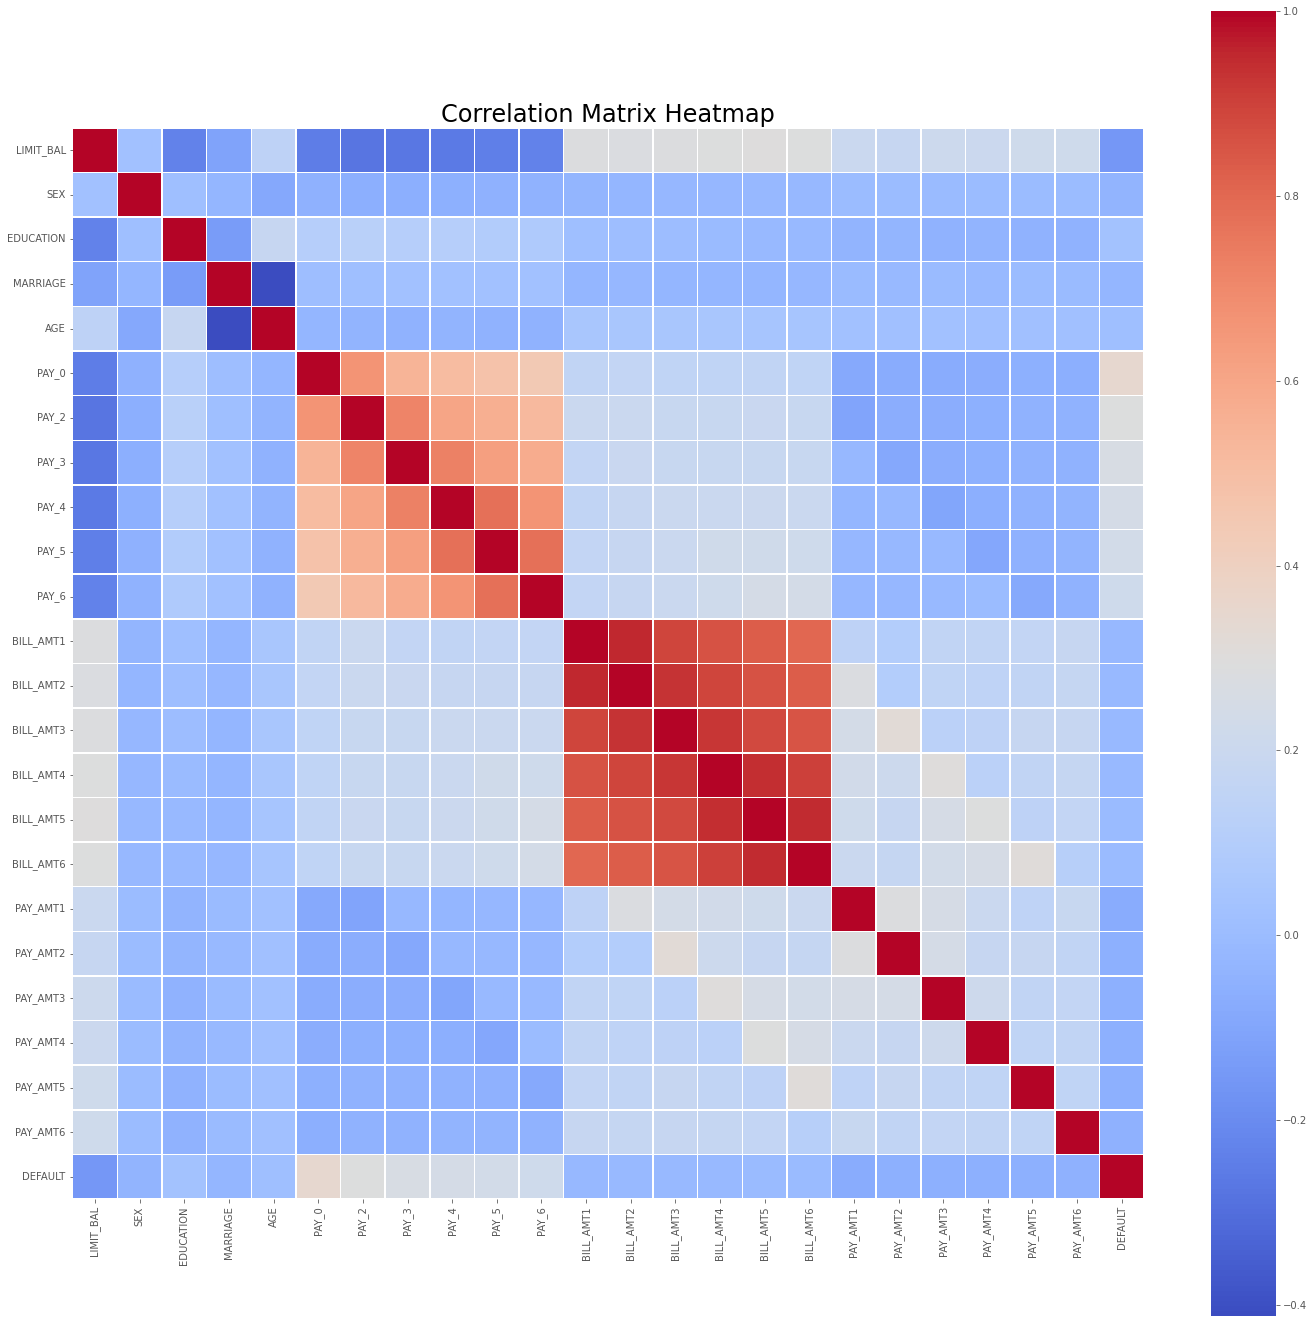

In [41]:
# EDA: Correlations 
corr = data.corr() 
fig, ax = plt.subplots(figsize=(24,24))
sns.heatmap(corr, cbar = True,  square = True, annot = False, fmt= '.1f', 
            xticklabels= True, yticklabels= True, cmap='coolwarm', linewidths=.5, ax=ax)
plt.title('Correlation Matrix Heatmap', size=24)
plt.show()

In [42]:
 from sklearn.decomposition import PCA

1. PAY_X columns

In [43]:
pay_scaled_data = scaled_data_df[pay_columns]
pay_scaled_data.head()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,1.942687,1.938346,-0.946291,-0.936042,-0.939939,-0.918576
1,-1.085297,1.938346,0.029300,0.076698,0.121739,2.241421
2,-0.075969,0.007434,0.029300,0.076698,0.121739,0.134756
3,-0.075969,0.007434,0.029300,0.076698,0.121739,0.134756
4,-1.085297,0.007434,-0.946291,0.076698,0.121739,0.134756


In [44]:
pca = PCA(n_components=3)
pay_principal_components = pca.fit_transform(pay_scaled_data)
pca.explained_variance_ratio_

array([0.68067139, 0.12692496, 0.07307861])

We can see that the first principal component account for almost 70% variance.

2. BILL_AMT columns

In [45]:
bill_amt_scaled_data = scaled_data_df[bill_columns]
bill_amt_scaled_data.head()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
0,-0.642501,-0.647399,-0.667993,-0.672497,-0.663059,-0.652724
1,-0.659219,-0.666747,-0.639254,-0.621636,-0.606229,-0.597966
2,-0.298560,-0.493899,-0.482408,-0.449730,-0.417188,-0.391630
3,-0.057491,-0.013293,0.032846,-0.232373,-0.186729,-0.156579
4,-0.578618,-0.611318,-0.161189,-0.346997,-0.348137,-0.331482


In [46]:
pca = PCA(n_components=3)
bill_amt_principal_components = pca.fit_transform(bill_amt_scaled_data)
pca.explained_variance_ratio_

array([0.90555253, 0.0509867 , 0.01860826])

Here we can see that the first principal component explains around 90% of the variance.

Creating new dataset where these columns are replaced with only first principal component:

In [47]:
# Copy of the scalled dataset
pca_scaled_data_df = scaled_data_df.copy()
pca_scaled_data_df.shape

(30000, 23)

In [48]:
# Removing columns
pca_scaled_data_df.drop(columns=bill_columns, inplace=True)
pca_scaled_data_df.drop(columns=pay_columns, inplace=True)
pca_scaled_data_df.shape

(30000, 11)

In [49]:
# Adding two new columns: two first principal components
pca_scaled_data_df['PAY_PCA'] = pay_principal_components[:,0]
pca_scaled_data_df['BILL_AMT_PCA'] = bill_amt_principal_components[:,0]
pca_scaled_data_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_PCA,BILL_AMT_PCA
0,-1.136720,0.810161,0.21187,-1.068797,-1.246020,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,-0.089739,-1.611148
1,-0.365981,0.810161,0.21187,0.849131,-1.029047,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,1.393204,-1.547595
2,-0.597202,0.810161,0.21187,0.849131,-0.161156,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,0.127181,-1.035874
3,-0.905498,0.810161,0.21187,-1.068797,0.164303,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,0.127181,-0.250712
4,-0.905498,-1.234323,0.21187,-1.068797,2.334029,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,-0.645677,-0.968951


#### Model selection

In this section, we're going to build various models and evaluate their performance.

Models that are going to be compared are:
- Model with all features (benchmark model from lectures)
- Model with selected features
- Model with selected polynomial features
- Model with reduced number features using PCA

For metrics we're going to calculate:
- Accuracy
- Precision
- Recall
- F1 score,

on both the training and testing dataset and draw the final concusion, which model performs the best.

In [50]:
def classification_metrics(y_pred, y_true):

  accuracy = metrics.accuracy_score(y_pred,y_true)
  precision = metrics.recall_score(y_pred,y_true)
  recall = metrics.precision_score(y_pred,y_true)
  f1 = metrics.f1_score(y_pred,y_true)
  return {
      "Accuraccy": accuracy,
      "Precision": precision,
      "Recall": recall,
      "F1": f1
  }


##### Model with all features

Searching for the best combination of hyperparameters

In [51]:
# Define the cross-validation approach
n_cv_logit = 5

# Define the maximum number of iterations
n_max_iter = 200

# Create an instance of the class LogisticRegression
logit_model = LogisticRegression(max_iter=n_max_iter)

# Define the search space for the hyperparameters
search_space = dict()
search_space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
search_space['C']       = [1e-5, 1e-4, 1e-3, 1e-1, 1, 10, 100]

# Create an instance of the class GridSearchCV with desired characteristics
logit_grid_search_cv_original = GridSearchCV(estimator=logit_model, 
                                             param_grid=search_space, 
                                             scoring='accuracy', 
                                             cv=n_cv_logit, 
                                             n_jobs=-1)

# Run the search algorithm and summarize resuts 
logit_grid_search_cv_original.fit(X_train, y_train)

print(f'Best score: {logit_grid_search_cv_original.best_score_:.4f}')
print('Best hyperparameters: %s' % logit_grid_search_cv_original.best_params_) 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

Best score: 0.8130
Best hyperparameters: {'C': 1e-05, 'penalty': 'none'}


In [52]:
# Create an instance of the class LogisticRegression with specific selection of hyperparameters
logit_ccd_original = LogisticRegression(penalty=logit_grid_search_cv_original.best_params_['penalty'], 
                                        C=logit_grid_search_cv_original.best_params_['C'])

# Fit the model
logit_ccd_original.fit(X_train, y_train)

# Predict outcomes in the training and testing subsamples and calculate accuracy
y_pred_train = logit_ccd_original.predict(X_train)
metrics_train = classification_metrics(y_pred_train, y_train)
print(metrics_train)

y_pred_test  = logit_ccd_original.predict(X_test)
metrics_test = classification_metrics(y_pred_test, y_test)
print(metrics_test)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


{'Accuraccy': 0.8134166666666667, 'Precision': 0.7026378896882494, 'Recall': 0.2752207401841067, 'F1': 0.39551835853131745}
{'Accuraccy': 0.8116666666666666, 'Precision': 0.6826347305389222, 'Recall': 0.26047220106626046, 'F1': 0.3770672546857773}


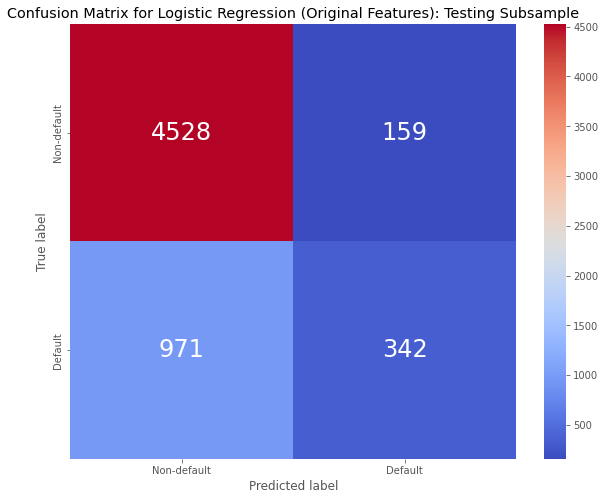

In [53]:
# Confusion matrix
plt.figure(figsize=(10,8))
logit_ccd_confusion_test = confusion_matrix(y_test, logit_ccd_original.predict(X_test))
sns.heatmap(logit_ccd_confusion_test, annot=True, annot_kws={'size':24}, cmap='coolwarm', fmt='d', 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Logistic Regression (Original Features): Testing Subsample')
plt.show()

In [54]:
# Saving the metrics for the training set
model_comparison_train = pd.DataFrame(columns=["Model", "Accuraccy", "Precision", "Recall", "F1"])
model_comparison_train.loc[0] = ["All features", metrics_train["Accuraccy"], metrics_train["Precision"], metrics_train["Recall"], metrics_train["F1"]]
model_comparison_train

,Model,Accuraccy,Precision,Recall,F1
0,All features,0.813417,0.702638,0.275221,0.395518


In [55]:
# Saving the metrics for the testing set
model_comparison_test = pd.DataFrame(columns=["Model", "Accuraccy", "Precision", "Recall", "F1"])
model_comparison_test.loc[0] = ["All features", metrics_test["Accuraccy"], metrics_test["Precision"], metrics_test["Recall"], metrics_test["F1"]]
model_comparison_test

,Model,Accuraccy,Precision,Recall,F1
0,All features,0.811667,0.682635,0.260472,0.377067


##### Model with selected features

Now, we're going to fit and evaluate model with only 4 most important columns:

In [56]:
selected_columns

['PAY_0', 'BILL_AMT1', 'BILL_AMT2', 'PAY_AMT1']

In [57]:
# New dataset of only selected features
dataset_selected = scaled_data_df[selected_columns].copy()
dataset_selected.head()

,PAY_0,BILL_AMT1,BILL_AMT2,PAY_AMT1
0,1.942687,-0.642501,-0.647399,-0.341942
1,-1.085297,-0.659219,-0.666747,-0.341942
2,-0.075969,-0.298560,-0.493899,-0.250292
3,-0.075969,-0.057491,-0.013293,-0.221191
4,-1.085297,-0.578618,-0.611318,-0.221191


Splitting new dataset:

In [58]:
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(dataset_selected, y, test_size=0.2, random_state=42)

print(f'Features: train={len(X_train_selected)} test={len(X_test_selected)}')
print(f'Target: train={len(y_train_selected)} test={len(y_test_selected)}')

Features: train=24000 test=6000
Target: train=24000 test=6000


Hyperparameter tuning:

In [59]:
# Define the cross-validation approach
n_cv_logit = 5

# Define the maximum number of iterations
n_max_iter = 200

# Create an instance of the class LogisticRegression
logit_model = LogisticRegression(max_iter=n_max_iter)

# Define the search space for the hyperparameters
search_space = dict()
search_space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
search_space['C']       = [1e-5, 1e-4, 1e-3, 1e-1, 1, 10, 100]

# Create an instance of the class GridSearchCV with desired characteristics
logit_grid_search_cv_original = GridSearchCV(estimator=logit_model, 
                                             param_grid=search_space, 
                                             scoring='accuracy', 
                                             cv=n_cv_logit, 
                                             n_jobs=-1)

# Run the search algorithm and summarize resuts 
logit_grid_search_cv_original.fit(X_train_selected, y_train_selected)

print(f'Best score: {logit_grid_search_cv_original.best_score_:.4f}')
print('Best hyperparameters: %s' % logit_grid_search_cv_original.best_params_) 

Best score: 0.8163
Best hyperparameters: {'C': 1, 'penalty': 'l2'}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

Fittng the model

In [60]:
# Create an instance of the class LogisticRegression with specific selection of hyperparameters
logit_selected_original = LogisticRegression(penalty=logit_grid_search_cv_original.best_params_['penalty'], 
                                        C=logit_grid_search_cv_original.best_params_['C'])

# Fit the model
logit_selected_original.fit(X_train_selected, y_train_selected)

# Predict outcomes in the training and testing subsamples and calculate accuracy
y_pred_train = logit_selected_original.predict(X_train_selected)
metrics_train = classification_metrics(y_pred_train, y_train_selected)
print(metrics_train)

y_pred_test  = logit_selected_original.predict(X_test_selected)
metrics_test = classification_metrics(y_pred_test, y_test)
print(metrics_test)


{'Accuraccy': 0.816125, 'Precision': 0.7007943512797882, 'Recall': 0.29832801052038327, 'F1': 0.4185004611938332}
{'Accuraccy': 0.8153333333333334, 'Precision': 0.6860254083484574, 'Recall': 0.2878903274942879, 'F1': 0.4055793991416309}


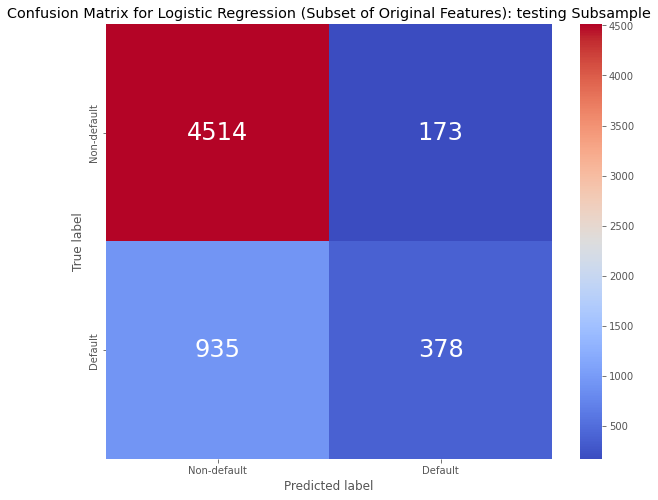

In [61]:
# Confusion matrix
plt.figure(figsize=(10,8))
logit_ccd_confusion_test = confusion_matrix(y_test, logit_selected_original.predict(X_test_selected))
sns.heatmap(logit_ccd_confusion_test, annot=True, annot_kws={'size':24}, cmap='coolwarm', fmt='d', 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Logistic Regression (Subset of Original Features): testing Subsample')
plt.show()

In [62]:
# Saving the metrics for the training set
model_comparison_train.loc[1] = ["Selected original features", metrics_train["Accuraccy"], metrics_train["Precision"], metrics_train["Recall"], metrics_train["F1"]]

In [63]:
# Saving the metrics for the testing set
model_comparison_test.loc[1] = ["Selected original features", metrics_test["Accuraccy"], metrics_test["Precision"], metrics_test["Recall"], metrics_test["F1"]]

##### Model with selected polynomial features

Now in this section, we going to fit the model again with only subset of selected features, but some of those features are synthetic polynomial features:


In [64]:
selected_columns_poly

['PAY_0', 'BILL_AMT1', 'PAY_0 BILL_AMT1', 'PAY_3 BILL_AMT1']

We can extract those features from the extended dataset or we can create them on our own by performing simple arithmetic operations:

In [65]:
# New dataset of only selected features we need
dataset_selected_poly = scaled_data_df[["PAY_0", "BILL_AMT1", "PAY_3"]].copy()
dataset_selected_poly["PAY_0 BILL_AMT1"] = dataset_selected_poly["PAY_0"] * dataset_selected_poly["BILL_AMT1"]
dataset_selected_poly["PAY_3 BILL_AMT1"] = dataset_selected_poly["PAY_3"] * dataset_selected_poly["BILL_AMT1"]
dataset_selected_poly.drop(columns=["PAY_3"], inplace=True)
dataset_selected_poly.head()

,PAY_0,BILL_AMT1,PAY_0 BILL_AMT1,PAY_3 BILL_AMT1
0,1.942687,-0.642501,-1.248179,0.607993
1,-1.085297,-0.659219,0.715448,-0.019315
2,-0.075969,-0.298560,0.022681,-0.008748
3,-0.075969,-0.057491,0.004368,-0.001685
4,-1.085297,-0.578618,0.627972,0.547541


Splitting new dataset:

In [66]:
X_train_selected_poly, X_test_selected_poly, y_train_selected_poly, y_test_selected_poly = train_test_split(dataset_selected_poly, y, test_size=0.2, random_state=42)

print(f'Features: train={len(X_train_selected_poly)} test={len(X_test_selected_poly)}')
print(f'Target: train={len(y_train_selected_poly)} test={len(y_test_selected_poly)}')

Features: train=24000 test=6000
Target: train=24000 test=6000


Hyperparameter tuning:

In [67]:
# Define the cross-validation approach
n_cv_logit = 5

# Define the maximum number of iterations
n_max_iter = 200

# Create an instance of the class LogisticRegression
logit_model = LogisticRegression(max_iter=n_max_iter)

# Define the search space for the hyperparameters
search_space = dict()
search_space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
search_space['C']       = [1e-5, 1e-4, 1e-3, 1e-1, 1, 10, 100]

# Create an instance of the class GridSearchCV with desired characteristics
logit_grid_search_cv_original = GridSearchCV(estimator=logit_model, 
                                             param_grid=search_space, 
                                             scoring='accuracy', 
                                             cv=n_cv_logit, 
                                             n_jobs=-1)

# Run the search algorithm and summarize resuts 
logit_grid_search_cv_original.fit(X_train_selected_poly, y_train_selected_poly)

print(f'Best score: {logit_grid_search_cv_original.best_score_:.4f}')
print('Best hyperparameters: %s' % logit_grid_search_cv_original.best_params_) 

Best score: 0.8202
Best hyperparameters: {'C': 1e-05, 'penalty': 'none'}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

Fitting the model:

In [68]:
# Create an instance of the class LogisticRegression with specific selection of hyperparameters
logit_selected_poly = LogisticRegression(penalty=logit_grid_search_cv_original.best_params_['penalty'], 
                                        C=logit_grid_search_cv_original.best_params_['C'])

# Fit the model
logit_selected_poly.fit(X_train_selected_poly, y_train_selected_poly)

# Predict outcomes in the training and testing subsamples and calculate accuracy
y_pred_train = logit_selected_poly.predict(X_train_selected_poly)
metrics_train = classification_metrics(y_pred_train, y_train_selected_poly)
print(metrics_train)

y_pred_test  = logit_selected_poly.predict(X_test_selected_poly)
metrics_test = classification_metrics(y_pred_test, y_test)
print(metrics_test)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


{'Accuraccy': 0.8202083333333333, 'Precision': 0.7105263157894737, 'Recall': 0.3195566409919218, 'F1': 0.4408448879098094}
{'Accuraccy': 0.8188333333333333, 'Precision': 0.6955017301038062, 'Recall': 0.30616907844630614, 'F1': 0.42517186673717605}


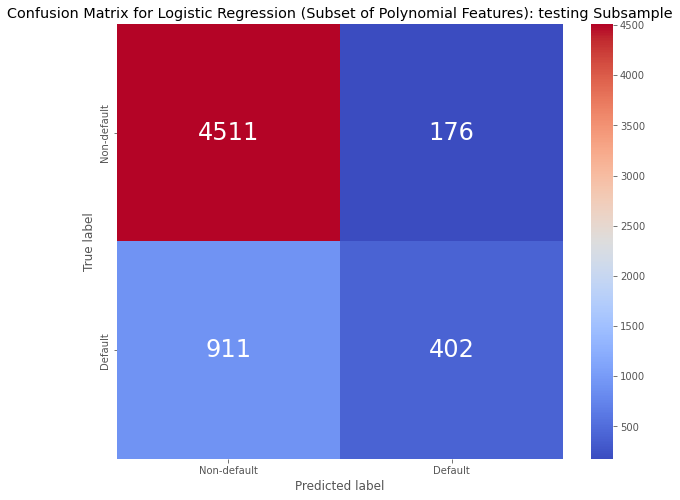

In [69]:
# Confusion matrix
plt.figure(figsize=(10,8))
logit_ccd_confusion_test = confusion_matrix(y_test, logit_selected_poly.predict(X_test_selected_poly))
sns.heatmap(logit_ccd_confusion_test, annot=True, annot_kws={'size':24}, cmap='coolwarm', fmt='d', 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Logistic Regression (Subset of Polynomial Features): testing Subsample')
plt.show()

In [70]:
# Saving the metrics for the training set
model_comparison_train.loc[2] = ["Selected polynomial features", metrics_train["Accuraccy"], metrics_train["Precision"], metrics_train["Recall"], metrics_train["F1"]]

In [71]:
# Saving the metrics for the testing set
model_comparison_test.loc[2] = ["Selected polynomial features", metrics_test["Accuraccy"], metrics_test["Precision"], metrics_test["Recall"], metrics_test["F1"]]

##### Model with PCA features

This is the last model we're going to try to fit and evaluate. Instad of two groups of columns (2x6 of them) which are highly correlated among each other, we're going to use the first principal component for each of of those two groups.



This is the dataset we're going to work with:

In [72]:
pca_scaled_data_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_PCA,BILL_AMT_PCA
0,-1.136720,0.810161,0.21187,-1.068797,-1.246020,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,-0.089739,-1.611148
1,-0.365981,0.810161,0.21187,0.849131,-1.029047,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,1.393204,-1.547595
2,-0.597202,0.810161,0.21187,0.849131,-0.161156,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,0.127181,-1.035874
3,-0.905498,0.810161,0.21187,-1.068797,0.164303,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,0.127181,-0.250712
4,-0.905498,-1.234323,0.21187,-1.068797,2.334029,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,-0.645677,-0.968951


Splitting the dataset:

In [73]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_scaled_data_df, y, test_size=0.2, random_state=42)

print(f'Features: train={len(X_train_pca)} test={len(X_test_pca)}')
print(f'Target: train={len(y_train_pca)} test={len(y_test_pca)}')

Features: train=24000 test=6000
Target: train=24000 test=6000


Hyperparameter tuning:

In [74]:
# Define the cross-validation approach
n_cv_logit = 5

# Define the maximum number of iterations
n_max_iter = 200

# Create an instance of the class LogisticRegression
logit_model = LogisticRegression(max_iter=n_max_iter)

# Define the search space for the hyperparameters
search_space = dict()
search_space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
search_space['C']       = [1e-5, 1e-4, 1e-3, 1e-1, 1, 10, 100]

# Create an instance of the class GridSearchCV with desired characteristics
logit_grid_search_cv_original = GridSearchCV(estimator=logit_model, 
                                             param_grid=search_space, 
                                             scoring='accuracy', 
                                             cv=n_cv_logit, 
                                             n_jobs=-1)

# Run the search algorithm and summarize resuts 
logit_grid_search_cv_original.fit(X_train_pca, y_train_pca)

print(f'Best score: {logit_grid_search_cv_original.best_score_:.4f}')
print('Best hyperparameters: %s' % logit_grid_search_cv_original.best_params_) 

Best score: 0.8020
Best hyperparameters: {'C': 1e-05, 'penalty': 'none'}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

In [75]:
# Create an instance of the class LogisticRegression with specific selection of hyperparameters
logit_pca = LogisticRegression(penalty=logit_grid_search_cv_original.best_params_['penalty'], 
                                        C=logit_grid_search_cv_original.best_params_['C'])

# Fit the model
logit_pca.fit(X_train_pca, y_train_pca)

# Predict outcomes in the training and testing subsamples and calculate accuracy
y_pred_train = logit_pca.predict(X_train_pca)
metrics_train = classification_metrics(y_pred_train, y_train_pca)
print(metrics_train)

y_pred_test  = logit_pca.predict(X_test_pca)
metrics_test = classification_metrics(y_pred_test, y_test)
print(metrics_test)


{'Accuraccy': 0.8015416666666667, 'Precision': 0.6739130434782609, 'Recall': 0.20383242532406537, 'F1': 0.31299581710659163}
{'Accuraccy': 0.7995, 'Precision': 0.6410256410256411, 'Recall': 0.19040365575019041, 'F1': 0.29359953024075164}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


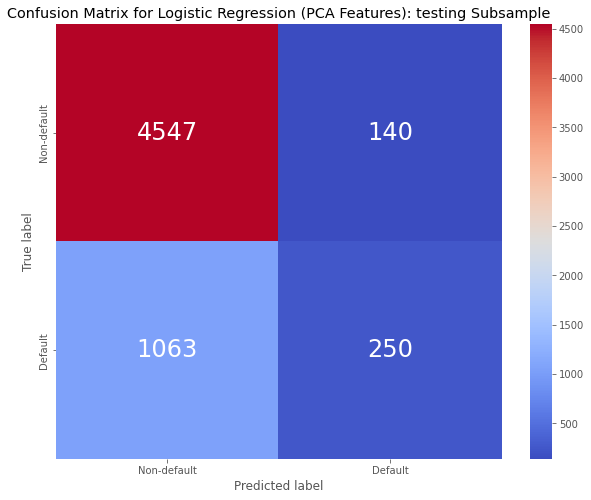

In [76]:
# Confusion matrix
plt.figure(figsize=(10,8))
logit_ccd_confusion_test = confusion_matrix(y_test, logit_pca.predict(X_test_pca))
sns.heatmap(logit_ccd_confusion_test, annot=True, annot_kws={'size':24}, cmap='coolwarm', fmt='d', 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Logistic Regression (PCA Features): testing Subsample')
plt.show()

In [77]:
# Saving the metrics for the training set
model_comparison_train.loc[3] = ["All features + PCA", metrics_train["Accuraccy"], metrics_train["Precision"], metrics_train["Recall"], metrics_train["F1"]]

In [78]:
# Saving the metrics for the testing set
model_comparison_test.loc[3] = ["All features + PCA", metrics_test["Accuraccy"], metrics_test["Precision"], metrics_test["Recall"], metrics_test["F1"]]

##### Overview

Now in this section, we will look at the metrics:
- Accuraccy
- Precision
- Recall
- F1

For model performance on both the training and the testing dataset. We will give the higher priority to metrics for testing dataset. Based on the confusion matrixes for all the models, from the sections above, we expect the model fitted on `selected number of polynomial features` to perform the best.

In [79]:
model_comparison_train

,Model,Accuraccy,Precision,Recall,F1
0,All features,0.813417,0.702638,0.275221,0.395518
1,Selected original features,0.816125,0.700794,0.298328,0.418500
2,Selected polynomial features,0.820208,0.710526,0.319557,0.440845
3,All features + PCA,0.801542,0.673913,0.203832,0.312996


In [80]:
model_comparison_test

,Model,Accuraccy,Precision,Recall,F1
0,All features,0.811667,0.682635,0.260472,0.377067
1,Selected original features,0.815333,0.686025,0.287890,0.405579
2,Selected polynomial features,0.818833,0.695502,0.306169,0.425172
3,All features + PCA,0.799500,0.641026,0.190404,0.293600


If we look now the two tables above, containing model performance metrics for the training and testing dataset, we'll can see that `Selected polynomial features` model is the best in both tables, across all the observed metrics.

Features that we used are following, data is scalled and predprocessed:

In [81]:
selected_columns_poly

['PAY_0', 'BILL_AMT1', 'PAY_0 BILL_AMT1', 'PAY_3 BILL_AMT1']

#### Exporting features


Exporting scaled, cleaned, predprocessed, selected and engineered features, so they can be used in the second assignment:

In [82]:
engineered_features = dataset_selected_poly.copy()
engineered_features['DEFAULT'] = y
engineered_features.tail()

,PAY_0,BILL_AMT1,PAY_0 BILL_AMT1,PAY_3 BILL_AMT1,DEFAULT
29995,-0.075969,1.870379,-0.142090,0.054803,0
29996,-1.085297,-0.672786,0.730172,0.636651,0
29997,3.961344,-0.647227,-2.563889,-1.281822,1
29998,0.933359,-0.717982,-0.670135,-0.021037,1
29999,-0.075969,-0.044739,0.003399,-0.001311,1


In [83]:
engineered_features.to_csv("UCI_Credit_Card (Engineered Features).csv")

### (b) Statistical Inference

In the lecture, we relied on the scikit-learn implementation of the logistic regression. However, this method does not provide output that would allow for statistical inference.

- To complement our analysis, run the logistic regression on the scaled features using the logit model provided in the statsmodels package. Make sure that the intercept is included in your model.
- Using the statsmodels method summary(), report the coefficients of the logistic regression and their respective standard errors, z-scores, and p-values. Provide comments regarding the statistical significance of the coefficients and draw conclusions regarding their importance and the quality of the model.

Adding an intercept, as reguired:

In [84]:
# Adding intercept
X_train_selected_poly_1 = sm.add_constant(X_train_selected_poly)
X_train_selected_poly_1.head()

,const,PAY_0,BILL_AMT1,PAY_0 BILL_AMT1,PAY_3 BILL_AMT1
21753,1.0,-0.075969,0.324598,-0.024659,0.009511
251,1.0,-0.075969,-0.298519,0.022678,-0.008747
22941,1.0,-0.075969,-0.411591,0.031268,0.389485
618,1.0,-0.075969,0.103425,-0.007857,0.003030
17090,1.0,-0.075969,0.819773,-0.062277,0.024020


In [85]:
# Fitting the model
log_reg = sm.Logit(y_train_selected_poly, X_train_selected_poly_1).fit()

Optimization terminated successfully.
         Current function value: 0.464764
         Iterations 6


In [86]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                DEFAULT   No. Observations:                24000
Model:                          Logit   Df Residuals:                    23995
Method:                           MLE   Df Model:                            4
Date:                Fri, 07 Jan 2022   Pseudo R-squ.:                  0.1217
Time:                        11:54:49   Log-Likelihood:                -11154.
converged:                       True   LL-Null:                       -12700.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.4314      0.018    -78.940      0.000      -1.467      -1.396
PAY_0               0.8864      0.018     50.509      0.000       0.852       0.921
BILL_AMT1          -0.3017      0.023    -12.894      0.000      -0.348      -0.256
PAY_0 BILL_AMT1     0.3613      0.026     13.721      0.000       0.310       0.413
PAY_3 BILL_AMT1    -0.1953      0.026     -7.650      0.000      -0.245      -0.145
===================================================================================
"""

From statsmodels summary, we can see that all four features (5 including an intercept) are non-zero coefficients.

Standard error look small relative to the values for the coefficients. But let's formally check the t-values and p-values.


In [87]:
# Model Coefficients
log_reg.params

const             -1.431354
PAY_0              0.886406
BILL_AMT1         -0.301650
PAY_0 BILL_AMT1    0.361320
PAY_3 BILL_AMT1   -0.195254
dtype: float64

T values is is a measurement of the precision with which the coefficient was measured. A low std error compared to a high coefficient produces a high t statistic, which signifies a high significance for your coefficient.

In [88]:
# T-values for the coefficients
log_reg.tvalues

const             -78.939844
PAY_0              50.509372
BILL_AMT1         -12.894074
PAY_0 BILL_AMT1    13.721412
PAY_3 BILL_AMT1    -7.650239
dtype: float64

P-values for coefficients is one of the most important statistics in the summary. The p-value for each independent variable tests the null hypothesis that the variable has no correlation with the dependent variable. If there is no correlation, there is no association between the changes in the independent variable and the shifts in the dependent variable.

It uses the following null and alternative hypotheses:

- The null hypothesis (H0): variable has no correlation with the dependent variable.
- The alternative hypothesis: (Ha): variable has correlation with the dependent variable.

Becase p-values are really small we can reject the null, and conslude that all coefficients are statistically significant, so all features we used are important.

In [89]:
# P-values for the coefficients
log_reg.pvalues

const              0.000000e+00
PAY_0              0.000000e+00
BILL_AMT1          4.860675e-38
PAY_0 BILL_AMT1    7.557872e-43
PAY_3 BILL_AMT1    2.006053e-14
dtype: float64

### (c) Optimal Probability Threshold

- Based on our in-class discussion of the optimal probability threshold, re-run the classification for logistic regression using a couple of candidate threshold values that were indicated by the ROC and PR curves (see the lecture notebook). 
  - Hint: Use the method predict_proba instead of the method predict in LogisticRegression and add one line of code that generates class predictions based on your selected threshold.

- Compare the models generated using different probability thresholds using the same key performance evaluation metrics you have applied in the section (a). Please make sure that the benchmark model (i.e., the model that was studied in the lecture, and which has the default probability threshold of 0.5) is included.
Discuss your findings.

In this section we're going to work with two models:
- Original/benchmark model from lectures - the one that uses all the features from dataset
- Our best performing model - the one that uses only a subset of features, including polynomial features

#### ALL FEATURES - ROC and PR curve




In [90]:
y_pred_train = logit_ccd_original.predict(X_train)
y_pred_test  = logit_ccd_original.predict(X_test)

Training (Scaled features):
Best threshold = 0.234895, Geometric mean = 0.682
----------------------------------------------------------------------------------------------------
Testing (Scaled features):
Best threshold = 0.225414, Geometric mean = 0.686
----------------------------------------------------------------------------------------------------


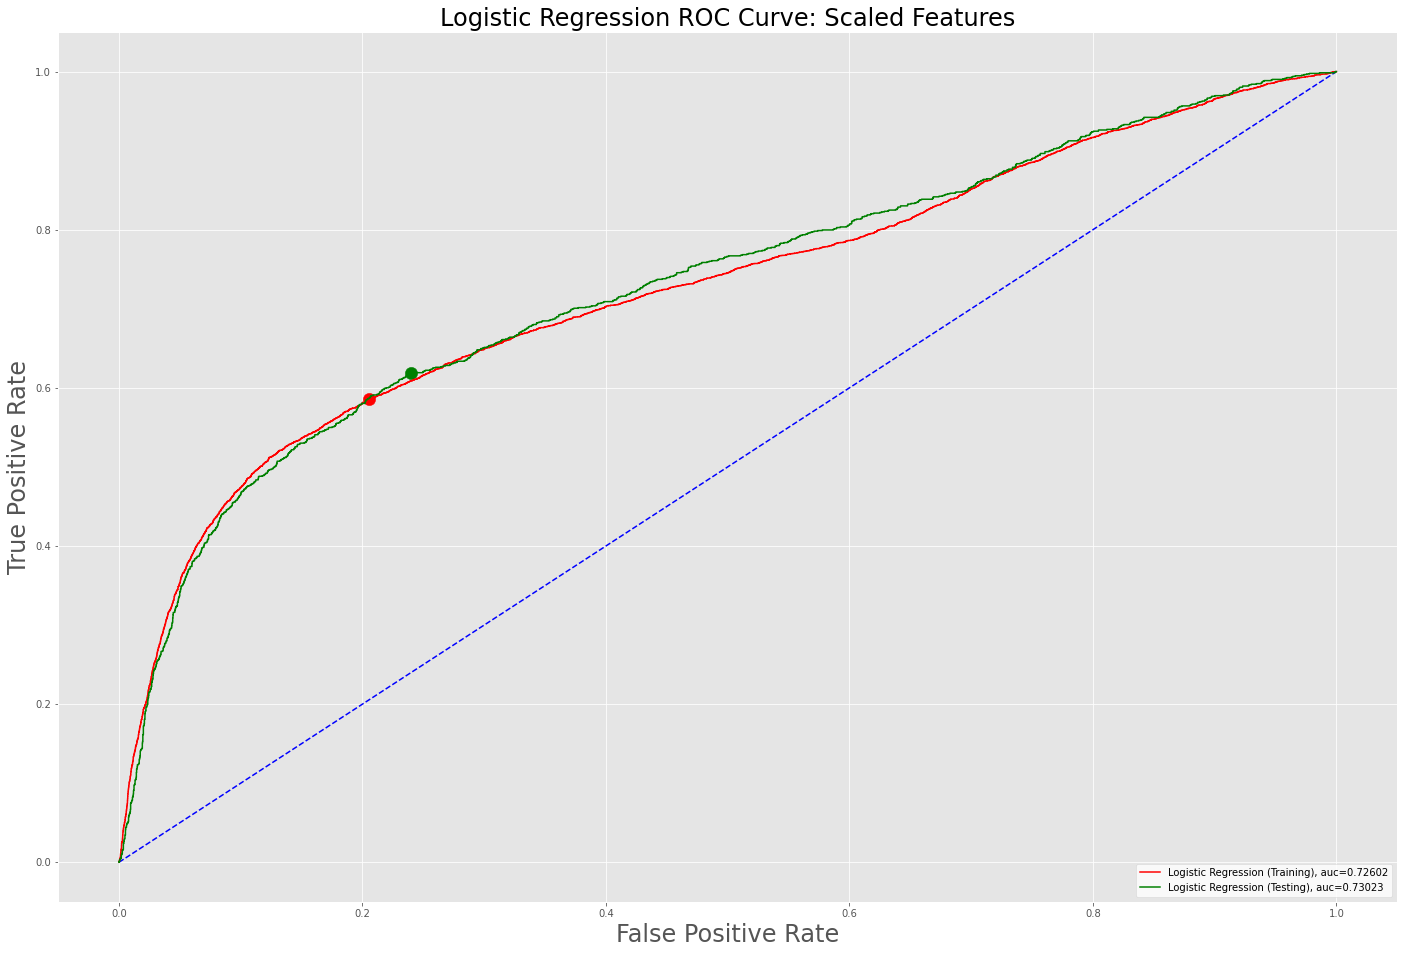

In [91]:
# Estimate probabilities, and calcualate relevant ROC/AUC scores 
y_scaled_pred_proba_train              = logit_ccd_original.predict_proba(X_train)[::,1]
fpr_scaled_train, tpr_scaled_train, threshold_scaled_train  = metrics.roc_curve(y_train, y_scaled_pred_proba_train)
auc_scaled_train                       = metrics.roc_auc_score(y_train, y_scaled_pred_proba_train)

y_scaled_pred_proba_test            = logit_ccd_original.predict_proba(X_test)[::,1]
fpr_scaled_test, tpr_scaled_test, threshold_scaled_test = metrics.roc_curve(y_test, y_scaled_pred_proba_test)
auc_scaled_test                     = metrics.roc_auc_score(y_test, y_scaled_pred_proba_test)

# Calculate the geometric mean for each threshold for the training and testing subsamples
vec_gmeans_scaled_train = np.sqrt(tpr_scaled_train * (1-fpr_scaled_train))
vec_gmeans_scaled_test  = np.sqrt(tpr_scaled_test * (1-fpr_scaled_test))

# locate the index of the largest g-mean
ix_scaled_train = np.argmax(vec_gmeans_scaled_train)
ix_scaled_test  = np.argmax(vec_gmeans_scaled_test)

# Summarize the results
print('Training (Scaled features):')
print('Best threshold = %f, Geometric mean = %.3f' % (threshold_scaled_train[ix_scaled_train], vec_gmeans_scaled_train[ix_scaled_train]))
print(100*'-')
print('Testing (Scaled features):')
print('Best threshold = %f, Geometric mean = %.3f' % (threshold_scaled_test[ix_scaled_test], vec_gmeans_scaled_test[ix_scaled_test]))
print(100*'-')

# Plot the ROC curve
plt.figure(figsize=(24,16))
plt.plot([0, 1], [0, 1], 'b--')
plt.plot(fpr_scaled_train, tpr_scaled_train, 'r-', label='Logistic Regression (Training), auc='+str(round(auc_scaled_train,6)))
plt.plot(fpr_scaled_test, tpr_scaled_test, 'g-', label='Logistic Regression (Testing), auc='+str(round(auc_scaled_test,6)))
plt.scatter(fpr_scaled_train[ix_scaled_train], tpr_scaled_train[ix_scaled_train], marker='o', color='red', s=150)
plt.scatter(fpr_scaled_test[ix_scaled_test], tpr_scaled_test[ix_scaled_test], marker='o', color='green', s=150)
plt.legend(loc=4, facecolor='white')
plt.xlabel('False Positive Rate', size=24)
plt.ylabel('True Positive Rate', size=24)
plt.title('Logistic Regression ROC Curve: Scaled Features', size=24)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Training (Scaled features):
Best threshold = 0.273952, F1 score = 0.526
----------------------------------------------------------------------------------------------------
Testing (Scaled features):
Best threshold = 0.996559, F1 score = nan
----------------------------------------------------------------------------------------------------


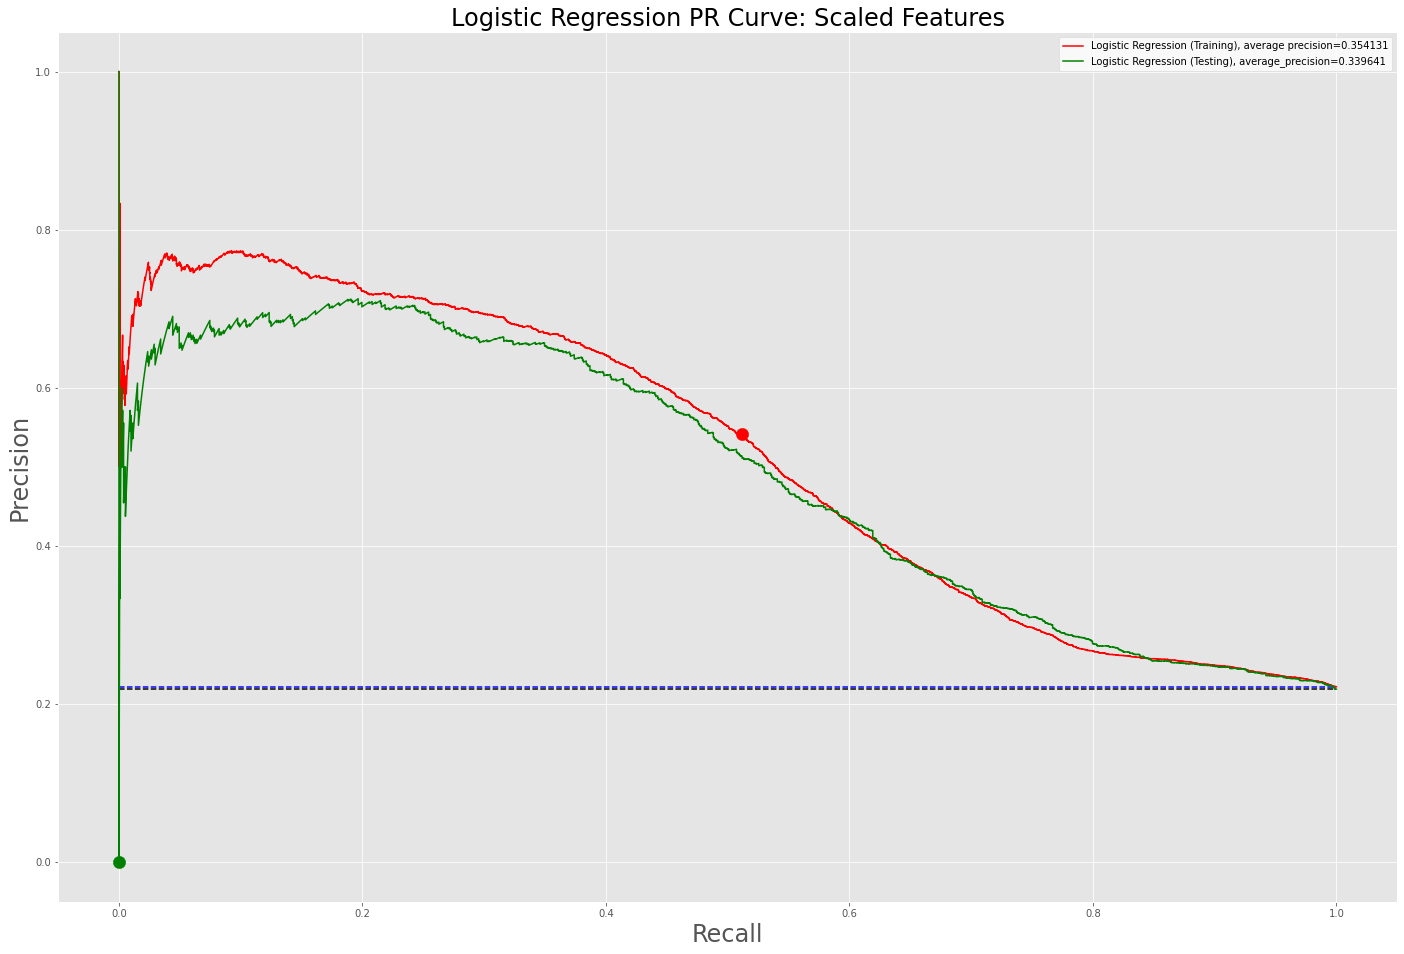

In [92]:
# Calculate the precision and recall for different values of threshold in the training and testing subsamples
precision_scaled_train, recall_scaled_train, threshold_scaled_train = metrics.precision_recall_curve(y_train, y_scaled_pred_proba_train)
average_precision_scaled_train = metrics.average_precision_score(y_train, y_pred_train)

precision_scaled_test, recall_scaled_test, threshold_scaled_test = metrics.precision_recall_curve(y_test, y_scaled_pred_proba_test)
average_precision_scaled_test = metrics.average_precision_score(y_test, y_pred_test)

# Calculate the F1 score
vec_f1_scaled_train = 2 * precision_scaled_train * recall_scaled_train / (precision_scaled_train + recall_scaled_train)
vec_f1_scaled_test  = 2 * precision_scaled_test * recall_scaled_test / (precision_scaled_test + recall_scaled_test)

# locate the index of the largest F1 score
ix_f1_scaled_train = np.argmax(vec_f1_scaled_train)
ix_f1_scaled_test  = np.argmax(vec_f1_scaled_test)

# Summarize the results
print('Training (Scaled features):')
print('Best threshold = %f, F1 score = %.3f' % (threshold_scaled_train[ix_f1_scaled_train], vec_f1_scaled_train[ix_f1_scaled_train]))
print(100*'-')
print('Testing (Scaled features):')
print('Best threshold = %f, F1 score = %.3f' % (threshold_scaled_test[ix_f1_scaled_test], vec_f1_scaled_test[ix_f1_scaled_test]))
print(100*'-')

# Calculate benchmark values for the training and testing subsamples
nopower_scaled_train = len(y_train[y_train==1]) / len(y_train)
nopower_scaled_test  = len(y_test[y_test==1]) / len(y_test)

# Plot the PR curve
plt.figure(figsize=(24,16))
plt.plot([0, 1], [nopower_scaled_train, nopower_scaled_train], 'b--')
plt.plot([0, 1], [nopower_scaled_test, nopower_scaled_test], 'k--')
plt.plot(recall_scaled_train, precision_scaled_train, 'r-', label='Logistic Regression (Training), average precision='+str(round(average_precision_scaled_train,6)))
plt.plot(recall_scaled_test, precision_scaled_test, 'g-', label='Logistic Regression (Testing), average_precision='+str(round(average_precision_scaled_test,6)))
plt.scatter(recall_scaled_train[ix_f1_scaled_train], precision_scaled_train[ix_f1_scaled_train], marker='o', color='red', s =150)
plt.scatter(recall_scaled_test[ix_f1_scaled_test], precision_scaled_test[ix_f1_scaled_test], marker='o', color='green', s=150)
plt.legend(loc=1, facecolor='white')
plt.xlabel('Recall', size=24)
plt.ylabel('Precision', size=24)
plt.title('Logistic Regression PR Curve: Scaled Features', size=24)
plt.show()

In [93]:
threshold = [0.5, 0.234895, 0.225414, 0.273952]

#### SELECTED POLYNOMIAL FEATURES - ROC and PR curve

In [94]:
y_pred_train = logit_selected_poly.predict(X_train_selected_poly)
y_pred_test  = logit_selected_poly.predict(X_test_selected_poly)

Training (Scaled features):
Best threshold = 0.213284, Geometric mean = 0.677
----------------------------------------------------------------------------------------------------
Testing (Scaled features):
Best threshold = 0.213216, Geometric mean = 0.678
----------------------------------------------------------------------------------------------------


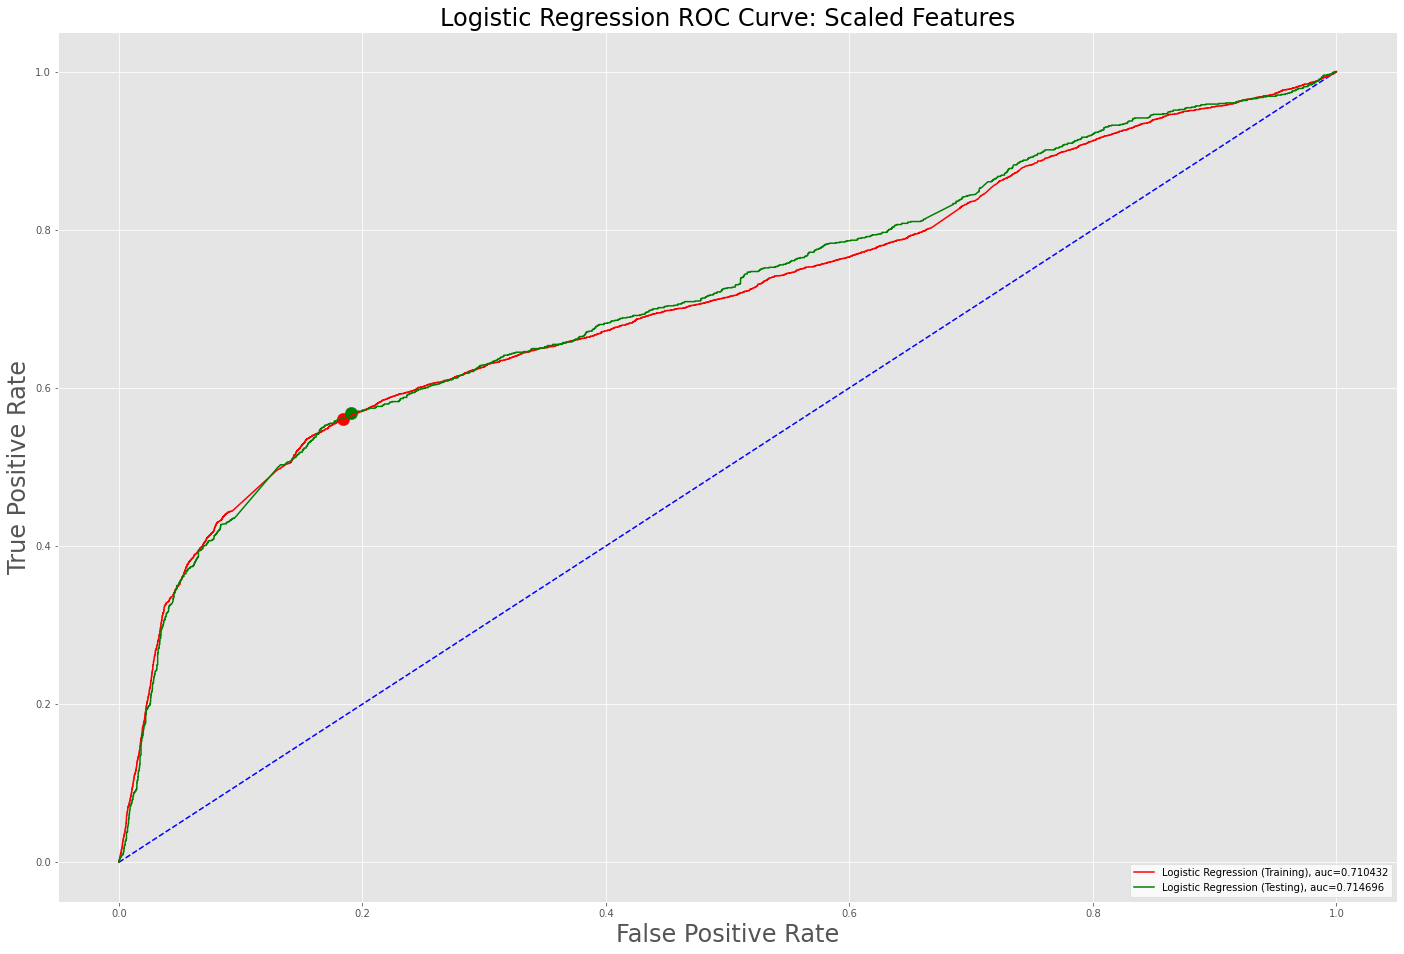

In [95]:
# Estimate probabilities, and calcualate relevant ROC/AUC scores 
y_scaled_pred_proba_train              = logit_selected_poly.predict_proba(X_train_selected_poly)[::,1]
fpr_scaled_train, tpr_scaled_train, threshold_scaled_train  = metrics.roc_curve(y_train, y_scaled_pred_proba_train)
auc_scaled_train                       = metrics.roc_auc_score(y_train, y_scaled_pred_proba_train)

y_scaled_pred_proba_test            = logit_selected_poly.predict_proba(X_test_selected_poly)[::,1]
fpr_scaled_test, tpr_scaled_test, threshold_scaled_test = metrics.roc_curve(y_test, y_scaled_pred_proba_test)
auc_scaled_test                     = metrics.roc_auc_score(y_test, y_scaled_pred_proba_test)

# Calculate the geometric mean for each threshold for the training and testing subsamples
vec_gmeans_scaled_train = np.sqrt(tpr_scaled_train * (1-fpr_scaled_train))
vec_gmeans_scaled_test  = np.sqrt(tpr_scaled_test * (1-fpr_scaled_test))

# locate the index of the largest g-mean
ix_scaled_train = np.argmax(vec_gmeans_scaled_train)
ix_scaled_test  = np.argmax(vec_gmeans_scaled_test)

# Summarize the results
print('Training (Scaled features):')
print('Best threshold = %f, Geometric mean = %.3f' % (threshold_scaled_train[ix_scaled_train], vec_gmeans_scaled_train[ix_scaled_train]))
print(100*'-')
print('Testing (Scaled features):')
print('Best threshold = %f, Geometric mean = %.3f' % (threshold_scaled_test[ix_scaled_test], vec_gmeans_scaled_test[ix_scaled_test]))
print(100*'-')

# Plot the ROC curve
plt.figure(figsize=(24,16))
plt.plot([0, 1], [0, 1], 'b--')
plt.plot(fpr_scaled_train, tpr_scaled_train, 'r-', label='Logistic Regression (Training), auc='+str(round(auc_scaled_train,6)))
plt.plot(fpr_scaled_test, tpr_scaled_test, 'g-', label='Logistic Regression (Testing), auc='+str(round(auc_scaled_test,6)))
plt.scatter(fpr_scaled_train[ix_scaled_train], tpr_scaled_train[ix_scaled_train], marker='o', color='red', s=150)
plt.scatter(fpr_scaled_test[ix_scaled_test], tpr_scaled_test[ix_scaled_test], marker='o', color='green', s=150)
plt.legend(loc=4, facecolor='white')
plt.xlabel('False Positive Rate', size=24)
plt.ylabel('True Positive Rate', size=24)
plt.title('Logistic Regression ROC Curve: Scaled Features', size=24)
plt.show()

Training (Scaled features):
Best threshold = 0.220203, F1 score = 0.516
----------------------------------------------------------------------------------------------------
Testing (Scaled features):
Best threshold = 0.217658, F1 score = 0.513
----------------------------------------------------------------------------------------------------


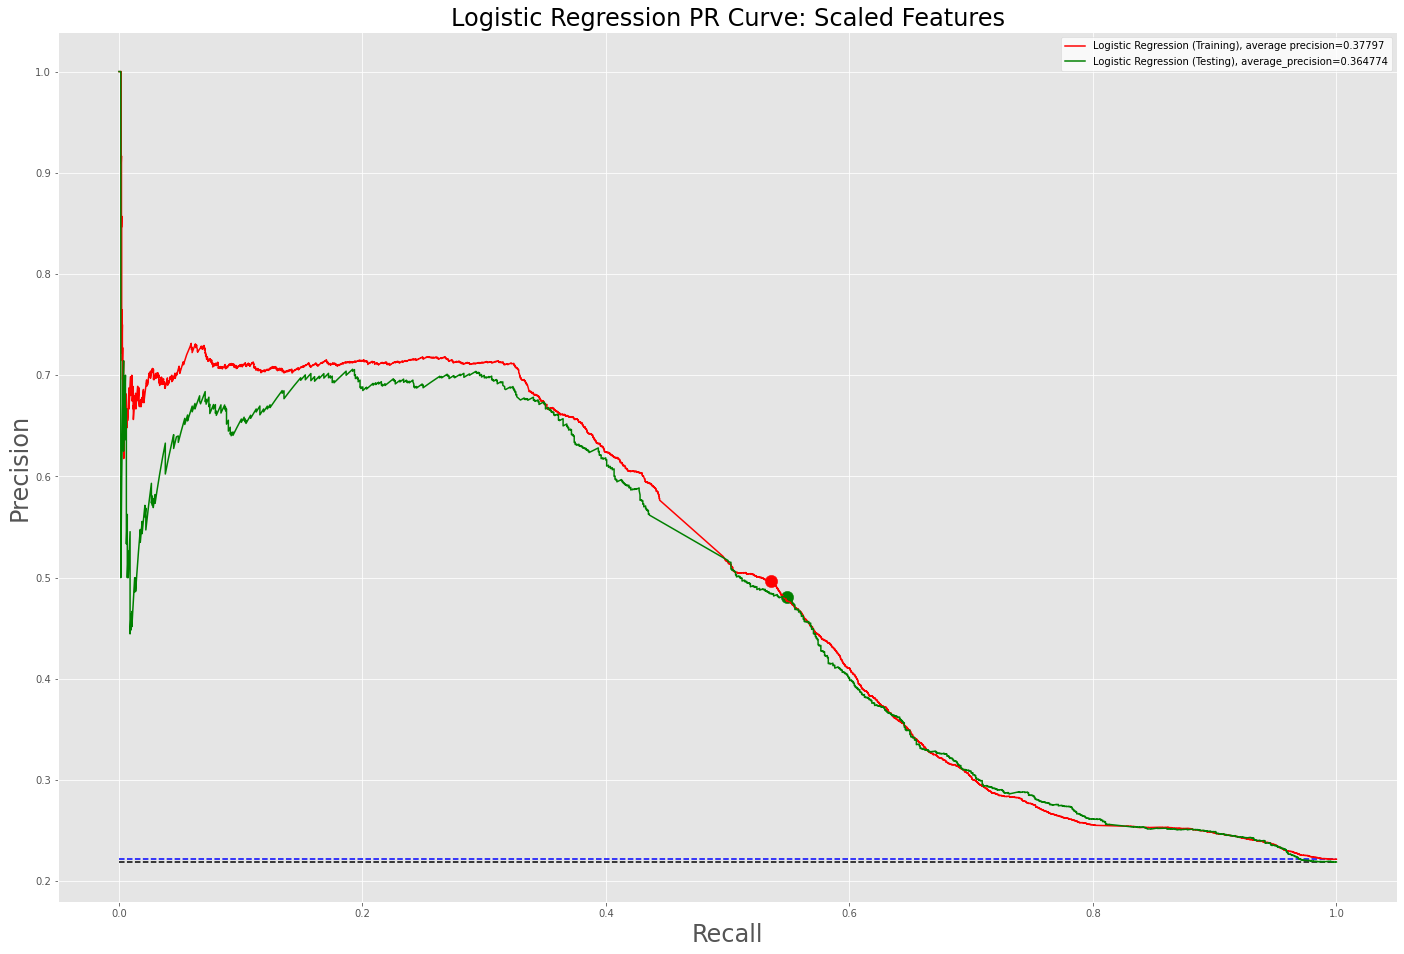

In [96]:
# Calculate the precision and recall for different values of threshold in the training and testing subsamples
precision_scaled_train, recall_scaled_train, threshold_scaled_train = metrics.precision_recall_curve(y_train, y_scaled_pred_proba_train)
average_precision_scaled_train = metrics.average_precision_score(y_train, y_pred_train)

precision_scaled_test, recall_scaled_test, threshold_scaled_test = metrics.precision_recall_curve(y_test, y_scaled_pred_proba_test)
average_precision_scaled_test = metrics.average_precision_score(y_test, y_pred_test)

# Calculate the F1 score
vec_f1_scaled_train = 2 * precision_scaled_train * recall_scaled_train / (precision_scaled_train + recall_scaled_train)
vec_f1_scaled_test  = 2 * precision_scaled_test * recall_scaled_test / (precision_scaled_test + recall_scaled_test)

# locate the index of the largest F1 score
ix_f1_scaled_train = np.argmax(vec_f1_scaled_train)
ix_f1_scaled_test  = np.argmax(vec_f1_scaled_test)

# Summarize the results
print('Training (Scaled features):')
print('Best threshold = %f, F1 score = %.3f' % (threshold_scaled_train[ix_f1_scaled_train], vec_f1_scaled_train[ix_f1_scaled_train]))
print(100*'-')
print('Testing (Scaled features):')
print('Best threshold = %f, F1 score = %.3f' % (threshold_scaled_test[ix_f1_scaled_test], vec_f1_scaled_test[ix_f1_scaled_test]))
print(100*'-')

# Calculate benchmark values for the training and testing subsamples
nopower_scaled_train = len(y_train[y_train==1]) / len(y_train)
nopower_scaled_test  = len(y_test[y_test==1]) / len(y_test)

# Plot the PR curve
plt.figure(figsize=(24,16))
plt.plot([0, 1], [nopower_scaled_train, nopower_scaled_train], 'b--')
plt.plot([0, 1], [nopower_scaled_test, nopower_scaled_test], 'k--')
plt.plot(recall_scaled_train, precision_scaled_train, 'r-', label='Logistic Regression (Training), average precision='+str(round(average_precision_scaled_train,6)))
plt.plot(recall_scaled_test, precision_scaled_test, 'g-', label='Logistic Regression (Testing), average_precision='+str(round(average_precision_scaled_test,6)))
plt.scatter(recall_scaled_train[ix_f1_scaled_train], precision_scaled_train[ix_f1_scaled_train], marker='o', color='red', s =150)
plt.scatter(recall_scaled_test[ix_f1_scaled_test], precision_scaled_test[ix_f1_scaled_test], marker='o', color='green', s=150)
plt.legend(loc=1, facecolor='white')
plt.xlabel('Recall', size=24)
plt.ylabel('Precision', size=24)
plt.title('Logistic Regression PR Curve: Scaled Features', size=24)
plt.show()

In [97]:
threshold.extend([0.213284, 0.213216, 0.220203, 0.217658])

#### Threshold comparison

From the ROC and PR curves for two previous models we got the following set of thresholds we're going to test the models with in order to find the optimal one.

Note: We're including the default threshold of 0.5 in the comparison as well.

In [98]:
threshold.append(0.5)

In [99]:
threshold.sort()
threshold

[0.213216,
 0.213284,
 0.217658,
 0.220203,
 0.225414,
 0.234895,
 0.273952,
 0.5,
 0.5]

Again, we're going to do comparison for both the training and testing datasets, giving the priority to the testing dataset.

In [100]:
threshold_comparison_train = pd.DataFrame(columns=["Model", "Accuraccy", "Precision", "Recall", "F1"])
threshold_comparison_test = pd.DataFrame(columns=["Model", "Accuraccy", "Precision", "Recall", "F1"])

In [101]:
def threshold_comparison(threshold, scores_df, model, X, y, name):

  index_start = 0
  if len(threshold_comparison_train.index) > 0:
    index_start = max(threshold_comparison_train.index) + 1

  for i, t in enumerate(threshold):
    y_pred = model.predict_proba(X)[::,1]
    y_pred = y_pred > t
    metrics_threshold = classification_metrics(y_pred, y)
    scores_df.loc[index_start + i] = [f"{name}: t={t}", metrics_threshold["Accuraccy"], metrics_threshold["Precision"], metrics_threshold["Recall"], metrics_threshold["F1"]]
    

##### Using all features model

In [102]:
threshold_comparison(threshold, threshold_comparison_train, logit_ccd_original, X_train, y_train, "All features")

In [103]:
threshold_comparison(threshold, threshold_comparison_test, logit_ccd_original, X_test, y_test, "All features")

##### Using only selected polynomial features model

In [104]:
threshold_comparison(threshold, threshold_comparison_train, logit_selected_poly, X_train_selected_poly, y_train_selected_poly, "Selected polynomial features")

In [105]:
threshold_comparison(threshold, threshold_comparison_test, logit_selected_poly, X_test_selected_poly, y_test_selected_poly, "Selected polynomial features")

#### Overview

In [106]:
# Importing this so that results table would be displayed as excel sheet, so it's filterable
from google.colab import data_table
data_table.enable_dataframe_formatter()

Training set:

From the training sample results bellow, we have following results (best two threasholds for each metric):
- Accuracy:
 - Selected polynomial features: t=0.5	
 - All features: t=0.5	
- Precision
 - Selected polynomial features: t=0.5	
 - All features: t=0.5	
- Recall
 - All feature model performed better than selected polynomial features model
 - All features: t=0.213216
- F1:
  - Selected polynomial features: t=0.220203	
  - Selected polynomial features: t=0.225414	

In [107]:
threshold_comparison_train

,Model,Accuraccy,Precision,Recall,F1
0,All features: t=0.213216,0.698167,0.390065,0.640240,0.484780
1,All features: t=0.213284,0.698250,0.390129,0.640053,0.484775
2,All features: t=0.217658,0.709833,0.401418,0.627654,0.489667
3,All features: t=0.220203,0.716708,0.408641,0.620139,0.492650
4,All features: t=0.225414,0.728500,0.422016,0.606425,0.497687
5,All features: t=0.234895,0.748292,0.448375,0.585760,0.507942
6,All features: t=0.273952,0.795833,0.542090,0.511741,0.526479
7,All features: t=0.5,0.813417,0.702638,0.275221,0.395518
8,All features: t=0.5,0.813417,0.702638,0.275221,0.395518
9,Selected polynomial features: t=0.213216,0.759167,0.464447,0.560774,0.508085


Testing set:

From the testing sample results bellow, we have following results (best two threasholds for each metric):
- Accuracy:
 - All features: t=0.213216		
 - All features: t=0.213284	
- Precision
 - Selected polynomial features: t=0.5	
 - All features: t=0.5	
- Recall
 - All feature model performed better than selected polynomial features model
 - All features: t=0.213284	
- F1:
  - Selected polynomial features: t=0.217658	
  - Selected polynomial features: t=0.225414	

In [108]:
threshold_comparison_test

,Model,Accuraccy,Precision,Recall,F1
9,All features: t=0.213216,0.696000,0.383173,0.638233,0.478857
10,All features: t=0.213284,0.696167,0.383349,0.638233,0.478994
11,All features: t=0.217658,0.708500,0.395494,0.628332,0.485437
12,All features: t=0.220203,0.715333,0.403044,0.625286,0.490149
13,All features: t=0.225414,0.729000,0.419205,0.618431,0.499692
14,All features: t=0.234895,0.748500,0.443807,0.589490,0.506379
15,All features: t=0.273952,0.790167,0.521226,0.504950,0.512959
16,All features: t=0.5,0.811667,0.682635,0.260472,0.377067
17,All features: t=0.5,0.811667,0.682635,0.260472,0.377067
18,Selected polynomial features: t=0.213216,0.756667,0.455156,0.568165,0.505420


Results look nearly the same both for the trainig set and testing set.

If we put ourselves into the shoes of bank manager, whose job is to predict and prevent client defaults, we would prioritize correct classification of default clients versus non-default clients.

In that case, for us, the more damage would be not classifying client as default one, than classifying the client as he is going to default even if he doesn't do so eventually. The worst thing that happends in that case is that we red flag a client for defaulting and have him under closer monitoring for dangerous activity.

It means, we would like to have a higher number of True Positives and low number of False Negatives.

The most common basic metric for that is often called recall or sensitivity.

So we will primarily look at the recall, but not ignoring the precision completely (precision-recall trade-off), we'll also take F1 measure into account.

For the recall, we can see that for both models, three thresholds are with the highest score:
- 0.213284
- 0.213216
- 0.217658

And if we look at F1 score, which takes both the recall and precision into account (it's biased towards the lower value of them two), we can see that model at the top is our polynomial feature model with the threshold of: 
- 0.217658

So as the final decision, we'll teake the threshold of `0.217658` as our threshold.

Another interesting observation is that polynomial features model performs better across all the metrics compared to the all features model when the default threshold os 0.5 is selected.